"""
Executive Summary:
-----------------------------

Chicago gets appeals on taxes. Appeals sometimes result in tax assessors reevaluating whether they need to make changes to tax bills to residents but sometimes they reject the appeal. We tried to understand what factors determine why some one appeals. Subsequently, we tried to understand what factors determine if someone gets a refund once they appeal. 
Please note that the purpose of these models is less about predicting. (This is important to note as we have done only 2 models - one to understand what determines an appeal and what determines the amount that someone gets back if appeal is successful. We have not included the model to predict what determines if someone would be successful when they appeal) 
 
We tried to run 2 models:

1) A Logit model that predicts whether someone appealed or not (no appeal(0) if the field appeal in the dataset is N/A and appeal(1) if the field appeal has 0 or a number in there) 
0s and 1s are nearly equally split in the data which indicates that we have a reasonable sample for the data. 

2) A Linear Regression model that predicts the amount of appeal. We only ran this model for non zero values of appeal to ensure no impact of bias due to the significant number of appeals resulting in no return. 
Key Data Cleansing Aspects
-----------------------------------------
We tried to drop all values of N/As for the fields we used in the models. A key thing that we observed in the data is that the field for beds / squarefoot is N/A for all condos. Since we found that Condo versus Non-Condo was a significant predictor in both our models, we preferred to not use squarefoot and beds in our models. 
We also found some values where av1 was negative. We dropped all these records from our analysis. 
We also realized there are some records which have appeal value greater than taxes. Since it didn’t make sense that someone got a higher return than the tax value itself, we decided to delete those records from our analysis. 

Results
-----------
***Logit Model: What factors determined whether someone would appeal?

Our best Logit model yielded a precision of 18%. Since the primary purpose of the model is to understand what factors determined whether someone would appeal or not to use the model for predictive purposes, we felt okay with the 18% score. Following are the variables that were significant at 95% in our analysis.
- Av1: We log transformed this variable. The coefficient is positive. This makes intuitive sense as higher the assessed value, the more likely someone is to appeal
- White: 	The coefficient is negative. This indicates that the higher the proportion of white demographic in the neighbourhood, less likely someone is to appeal
- Black:	The coefficient is negative. This indicates that the higher the proportion of black demographic in the neighbourhood, less likely someone is to appeal
- Hispanic: The coefficient is negative. This indicates that the higher the proportion of hispanic demographic in the neighbourhood, less likely someone is to appeal. (this value though is of lesser magnitude than White and Black) 
- Medhinc: the coefficient is negative.Higher the median household income in the area the less likely someone is to appeal. This value is very low though. 
- Poverty: the coefficient is negative.Higher the poverty in the area the less likely someone is to appeal. This is not inline with what we observed with the median household income. But it makes sense to use this variable as the coefficient for medhinc is very low
- College: the coefficient is positive.Higher the proportion of college (4 year degree) graduate in the neighborhood the more likely someone is to appeal.
- condo/non-condo: the coefficient is positive.Condo owners are more likely to appeal than non-condo owners
- Homeowner:the coefficient is positive. Homeowners are more likely to appeal. 
Most of the other variables we have are not significant at 95% levels. 


***Linear Regression Model: What factors determined how much someone would get return in appeal?

Our best Linear regression model yielded an Adjusted R-Squared of 60%. Across different models that we created and tested, the following variables were most often found to be significant at 95% in our analysis.
- av1 : Higher the value of av1, higher the value of appeal or monetary return
- Taxes : Higher the value of taxes, higher the value of appeal
- Avg_school_score: Higher the average school score, higher the value of appeal
- tri_Northwest Suburban Cook County: The properties in Northwest Suburban cook county get lower appeal than Chicago. It is probably due to the difference in assessor
- tri_Southwest Suburban Cook County:The properties in Southwest Suburban cook county get lower appeal than Chicago. It is probably due to the difference in assessor

Most of the other variables we have tried were not significant at 95% levels

Additional Next steps:
--------------------------------
We would have ideally liked to have the data of beds / square foot for condos as well so that we could leverage that set of information in the models. 
We are also missing total square footage of the lot. This might have had an impact on the return one got. 
The data for demographics seem overlapping as white + black + hispanic + asian is sometimes more than 100%. Having a mutually exclusive set of these variables would have helped drive clearer analysis. We tried to adjust this by creating Race (white vs non-white category) and ethnicity (hispanic vs non-hispanic category) by using a proportion threshold of 0.5 above.
It wasn’t clear why tax as a ratio of appraised value is such a high number. Having a cleaner set of data on Value / Tax / Assessed Value would have helped cleaner analysis. 
Certain Assessors might be more stringent than others. Having assessor information and the information of the person who reviewed and decided on the appeal would be helpful. 
Tax year information may be helpful too. Difference due to different assessor at different time or changes in property value over time couldn't be accounted for in the current data.
"""

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import combinations
import statsmodels.formula.api as sm1
import scipy

In [ ]:
#import data
df = pd.read_csv("project2data.csv")
org = df

In [ ]:
#df = org

In [ ]:
print(df.shape)
df.head()

(19036, 26)


,pin14,tri,pdir,pstreet,pcity,tcity,condo,av1,value,taxes,...,poverty,college,squarefoot,beds,walkscore,walkfac,elem_score,high_school_score,avg_school_score,appeal
0,2.033200e+13,Chicago,S,LASALLE,CHICAGO,CHICAGO,Non-condo,11558.0,108000,1585.2000,...,0.408146,0.149720,1223.0,3.0,73,Very Walkable,1,6,4,0.0
1,2.414410e+13,Chicago,S,SAWYER,CHICAGO,CHICAGO,Non-condo,19357.0,215000,3032.4399,...,0.004164,0.223537,1320.0,3.0,55,Somewhat Walkable,10,8,9,0.0
2,1.408420e+13,Chicago,W,AINSLIE,CHICAGO,CHICAGO,Non-condo,76189.0,1364225,11644.6900,...,0.263047,0.344634,4800.0,12.0,82,Very Walkable,5,2,4,4199.0
3,1.419130e+13,Chicago,N,OAKLEY,CHICAGO,CHICAGO,Non-condo,61525.0,1091500,3215.5500,...,0.011499,0.517047,2620.0,4.0,76,Very Walkable,8,10,9,39109.0
4,1.129100e+13,Chicago,W,JUNEWAY,CHICAGO,CHICAGO,Non-condo,44434.0,380000,7200.3799,...,0.323849,0.182889,1976.0,4.0,66,Somewhat Walkable,2,1,2,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19036 entries, 0 to 19035
Data columns (total 26 columns):
pin14                19036 non-null float64
tri                  19036 non-null object
pdir                 13509 non-null object
pstreet              19035 non-null object
pcity                19035 non-null object
tcity                19036 non-null object
condo                19036 non-null object
av1                  18991 non-null float64
value                19036 non-null int64
taxes                19036 non-null float64
homeowner            19036 non-null int64
white                18914 non-null float64
black                18914 non-null float64
hispanic             18914 non-null float64
asian                18914 non-null float64
medhinc              18914 non-null float64
poverty              18914 non-null float64
college              18914 non-null float64
squarefoot           13915 non-null float64
beds                 13915 non-null float64
walkscore            

# Part1: What are the factors that lead a property owner to appeal?

## Data cleaning


### FIX Pin14

In [ ]:
#FIX Pin 
df['pin14'] = df['pin14'].astype(str).str[:-2]
#df.pin14.sample
print(df.pin14.str.len().value_counts())

#df['pin14'] = df.pin14.astype(str)
#df.pin14.str.len().value_counts()

14    18976
13       60
Name: pin14, dtype: int64


In [ ]:
df['pin14'] = df.pin14.str.pad(width=14, side='left', fillchar='0')
df.pin14.str.len().value_counts()

14    19036
Name: pin14, dtype: int64

## Use PIN to create Area/Subarea

In [ ]:
df['Area_Code'] = df.pin14.str[:2].astype('category')
df['Sub_Area_Code'] = df.pin14.str[2:4].astype('category')

print('Area Code', df.Area_Code.unique())
print('Sub Area Code',df.Sub_Area_Code.unique())

Area Code [20, 24, 14, 11, 17, ..., 28, 22, 31, 33, 23]
Length: 25
Categories (25, object): [20, 24, 14, 11, ..., 22, 31, 33, 23]
Sub Area Code [33, 14, 08, 19, 29, ..., 36, 16, 02, 26, 35]
Length: 36
Categories (36, object): [33, 14, 08, 19, ..., 16, 02, 26, 35]


## Missing Values

In [ ]:
df.isna().sum()

pin14                    0
tri                      0
pdir                  5527
pstreet                  1
pcity                    1
tcity                    0
condo                    0
av1                     45
value                    0
taxes                    0
homeowner                0
white                  122
black                  122
hispanic               122
asian                  122
medhinc                122
poverty                122
college                122
squarefoot            5121
beds                  5121
walkscore                0
walkfac                  0
elem_score               0
high_school_score        0
avg_school_score         0
appeal               10018
Area_Code                0
Sub_Area_Code            0
dtype: int64

## Numeric variables

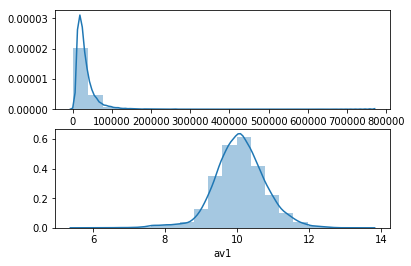

In [ ]:
plt.subplot(2,1,1)
sns.distplot((df.av1[~(df['av1']<0)]), bins=20)
plt.subplot(2,1,2)
sns.distplot(np.log(df.av1[~(df['av1']<0)]), bins=20)

### Create Numeric variables

In [ ]:
#create tax rate using av1
df['tax_rate']  = df.taxes/df.av1 * 100
df.tax_rate.describe()

count    18991.000000
mean        17.156834
std         14.385367
min       -386.719178
25%         13.414911
50%         15.823960
75%         19.537388
max        899.375517
Name: tax_rate, dtype: float64

In [ ]:
#create tax rate using value
df['tax_rate2']  = df.taxes/df.value * 100
df.tax_rate2.describe()

count    19036.000000
mean         1.624710
std          0.989713
min          0.000000
25%          1.054572
50%          1.403601
75%          1.911060
max         13.954771
Name: tax_rate2, dtype: float64

We wanted to use tax rate in our model. From the data it looks like the taxes are set up on the 'value' field rather than 'av1' (assessed value), which doesn't make intutive sense. Since it is not clear how it is set up we decided not to use it for this excercise.

## Categorical variables

### Create binary inficator for appeal

In [ ]:
#create binary flag to appeal = Yes/No as 1/0
df['appeal2'] = np.where(df.appeal >=0, 1,0)
df.appeal2.value_counts()

0    10018
1     9018
Name: appeal2, dtype: int64

In [ ]:
#create binary flag for appeal that were successful = Yes/No as 1/0
df['appeal_success'] = np.where(df.appeal >0, 1, 0)

df.appeal_success.value_counts()

0    13449
1     5587
Name: appeal_success, dtype: int64

In [ ]:
pd.crosstab(df.appeal2, df.appeal_success)

appeal_success,0,1
appeal2,,
0,10018,0
1,3431,5587


## Create variable for Dominant Race in a Neighborhood

Since the Race/Hispanic information is presented as a proportion in the data, they would be highly correlated (as also confirmed from the correlation plot below). For example, if proportion of white increase, the proportion of other races would decrease. So we decided to create categorical variable for Race (white vs non-white) and ethnicity (hispanic vs non-hispanic).

In [ ]:
# Create a binary field for Race and Hispanic fields - majority vs minority

def label_race (col):
    if col['white'] == "NA" :
        return "NA"
    elif col['white']> 0.5 :
        return 'White'
    elif col['white']< 0.5 :
        return 'Non-White'
#  if dt2['black']> 0.5 :
#      return 'black'
#  if dt2['asian']> 0.5 :
#      return 'asian'
#   return 'Other'


def label_hisp (col):
    if col['hispanic'] == "NA" :
        return "NA"
    elif col['hispanic']> 0.5 :
        return 'Hispanic'
    elif col['hispanic']< 0.5 :
        return 'Non-hispanic'


df['race'] = df.apply(label_race, axis=1)
df['ethnicity'] = df.apply(label_hisp, axis=1)
print(df.race.value_counts())
print(df.ethnicity.value_counts())

White        14148
Non-White     4766
Name: race, dtype: int64
Non-hispanic    16898
Hispanic         2016
Name: ethnicity, dtype: int64


# Correlation

In [ ]:
categoricals = set(df.columns[(df.dtypes == 'category')])
categoricals

{'Area_Code', 'Sub_Area_Code'}

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19036 entries, 0 to 19035
Data columns (total 34 columns):
pin14                19036 non-null object
tri                  19036 non-null object
pdir                 13509 non-null object
pstreet              19035 non-null object
pcity                19035 non-null object
tcity                19036 non-null object
condo                19036 non-null object
av1                  18991 non-null float64
value                19036 non-null int64
taxes                19036 non-null float64
homeowner            19036 non-null int64
white                18914 non-null float64
black                18914 non-null float64
hispanic             18914 non-null float64
asian                18914 non-null float64
medhinc              18914 non-null float64
poverty              18914 non-null float64
college              18914 non-null float64
squarefoot           13915 non-null float64
beds                 13915 non-null float64
walkscore            1

In [ ]:
#convert object to category
for col in ['pin14','pdir','pcity','pstreet','tcity','walkfac','race','ethnicity']:
    df[col] = df[col].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19036 entries, 0 to 19035
Data columns (total 34 columns):
pin14                19036 non-null category
tri                  19036 non-null object
pdir                 13509 non-null category
pstreet              19035 non-null category
pcity                19035 non-null category
tcity                19036 non-null category
condo                19036 non-null object
av1                  18991 non-null float64
value                19036 non-null int64
taxes                19036 non-null float64
homeowner            19036 non-null int64
white                18914 non-null float64
black                18914 non-null float64
hispanic             18914 non-null float64
asian                18914 non-null float64
medhinc              18914 non-null float64
poverty              18914 non-null float64
college              18914 non-null float64
squarefoot           13915 non-null float64
beds                 13915 non-null float64
walkscore   

In [ ]:
categoricals = set(df.columns[(df.dtypes == 'category')])
categoricals

{'Area_Code',
 'Sub_Area_Code',
 'ethnicity',
 'pcity',
 'pdir',
 'pin14',
 'pstreet',
 'race',
 'tcity',
 'walkfac'}

In [ ]:
numericals = set(df.columns) - categoricals #- set(['pin14','tri','pdir','pstreet','pcity','tcity','condo','homeowner'])
numericals

{'appeal',
 'appeal2',
 'appeal_success',
 'asian',
 'av1',
 'avg_school_score',
 'beds',
 'black',
 'college',
 'condo',
 'elem_score',
 'high_school_score',
 'hispanic',
 'homeowner',
 'medhinc',
 'poverty',
 'squarefoot',
 'tax_rate',
 'tax_rate2',
 'taxes',
 'tri',
 'value',
 'walkscore',
 'white'}

In [ ]:
def corr_plot(ax, corr, labels, sub=False, plot_title="", cmap="coolwarm",
              triangle=False, upper=True, annot_size=20,
              decimals=2,
              partial=False, xlabs=None, ylabs=None):
    """
    Plot a correlation matrix.
    Inputs:
        - ax: (Axes) instance to draw the plot on
        - corr: (2D-array) the correlation matrix
        - labels: ([str]) names of the variables for plotting
        - sub: (Bool) whether the plot is a subplot, control for the title font
        - plot_title: (string) title of the plot
        - cmap: (string) color map for the heat map
        - triangle: (Bool) whether to plot the upper or lower part of the matrix
            as it's symmetric
        - upper: (Bool) if only plot half of the plot, whether it's upper
        - font_size: (int, int, int) font size for title, axis, and tick
        - annot_size: (int) font size for the correlation number annotations
        - decimals: (int) round the correlation coefficients to
    """
    default = {'ax': ax,
               'cmap': cmap, 'cbar_kws': {"shrink": .5},
               'vmax': 1, 'vmin': -1, 'center': 0,
               'square': True, 'linewidths': 0.5}
    if annot_size != 0:
        default['annot'] = True
        default['annot_kws'] = {"size": annot_size}
    corr = corr.round(decimals)

    if triangle:
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[[np.triu_indices_from, np.tril_indices_from][int(upper)](
            mask)] = True
        sns.heatmap(corr, mask=mask, **default)
    else:
        sns.heatmap(corr, **default)

#reference: Kunyu's TA demo notebook

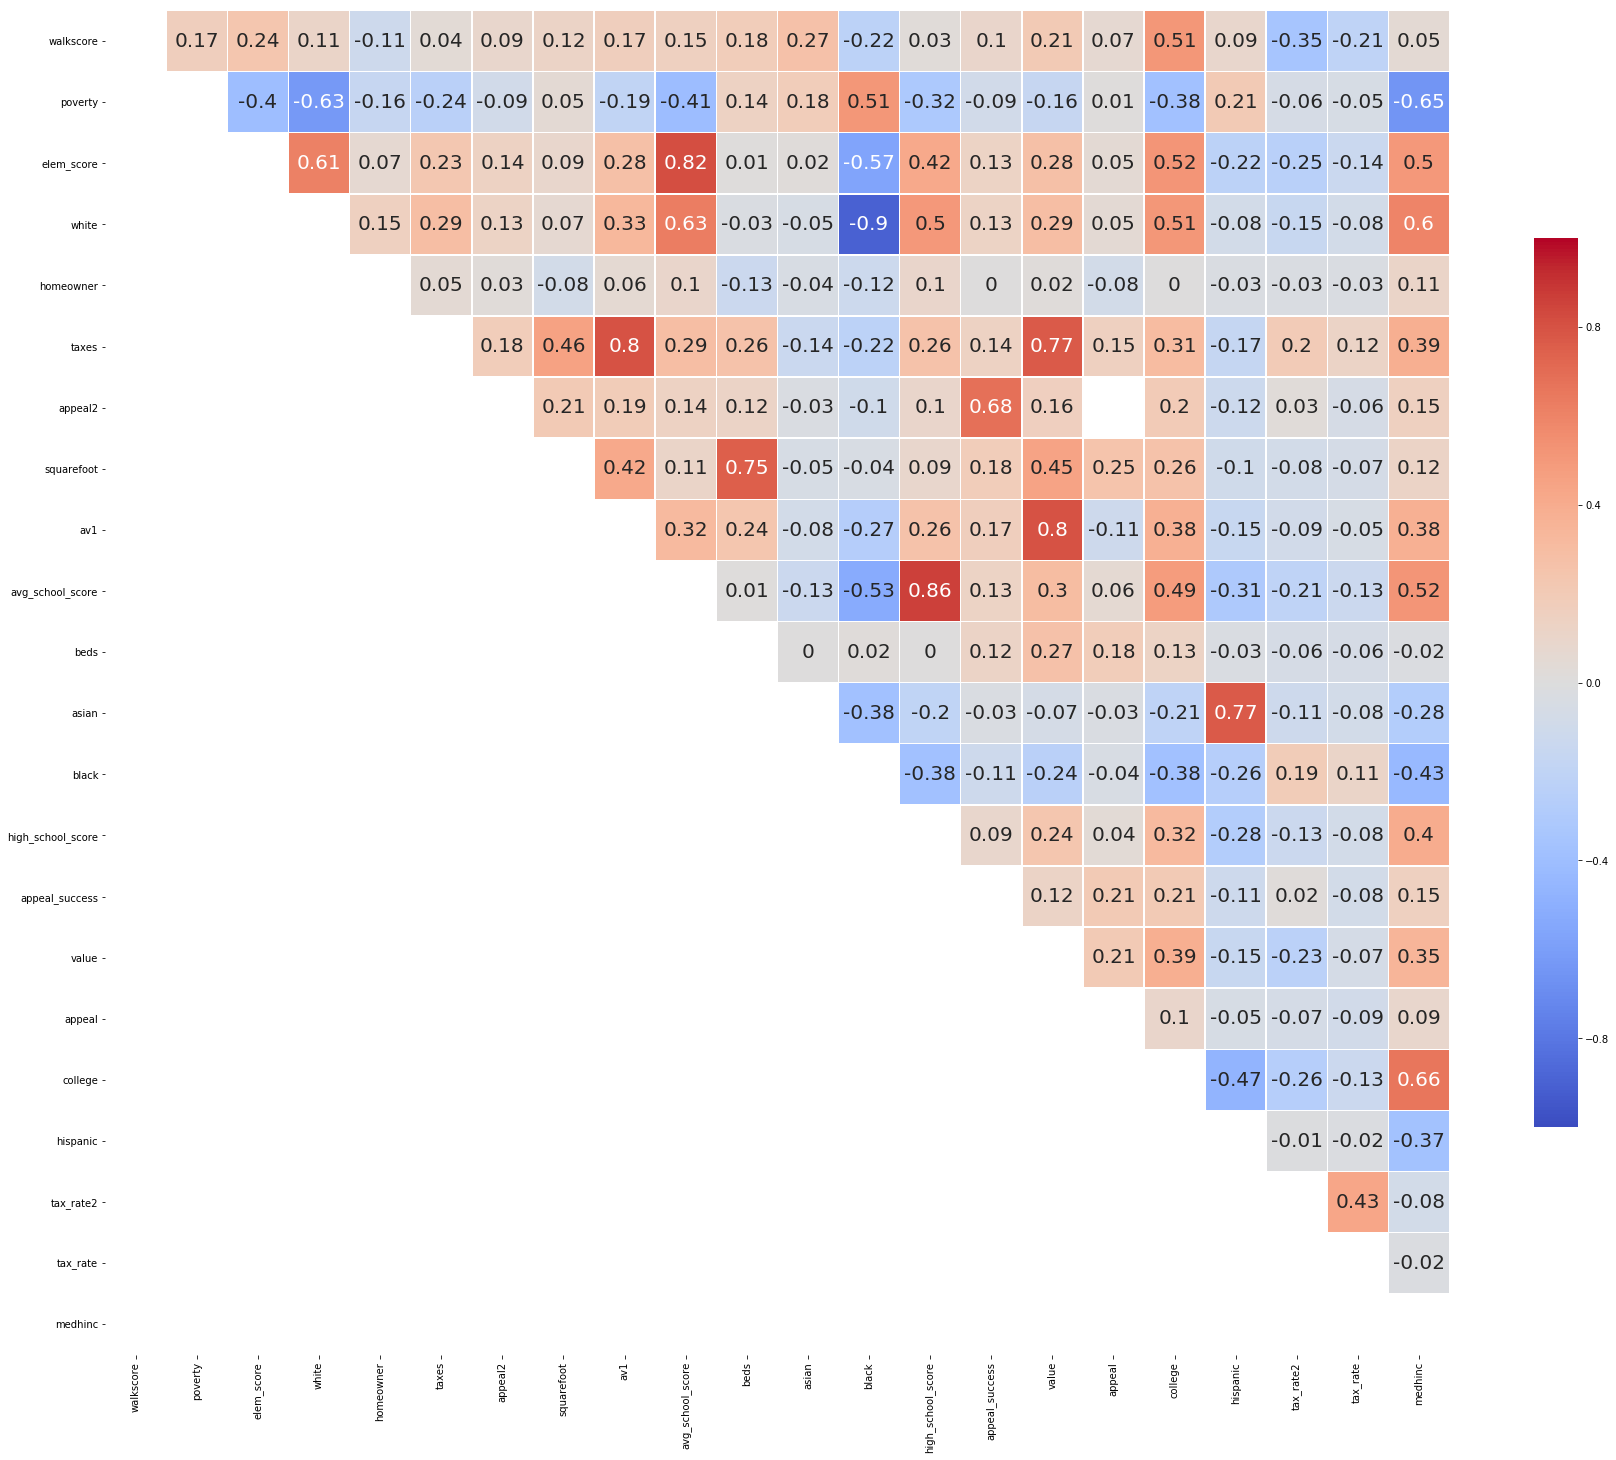

In [ ]:
corr = df[numericals].corr()

fig, ax = plt.subplots(figsize=(25, 25))
corr_plot(ax, corr, labels=numericals, triangle=True, upper=True, partial=True)
fig.tight_layout()

In [ ]:
#sns.pairplot(df[numericals])

# Create dummmy variables

Create dummy variables for condo, homeowner, tri, area code, sub area code, race and ethinicity

In [ ]:
df = pd.get_dummies(data=df, columns=['condo','homeowner','tri','Area_Code','Sub_Area_Code','race','ethnicity'],drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19036 entries, 0 to 19035
Data columns (total 92 columns):
pin14                                 19036 non-null category
pdir                                  13509 non-null category
pstreet                               19035 non-null category
pcity                                 19035 non-null category
tcity                                 19036 non-null category
av1                                   18991 non-null float64
value                                 19036 non-null int64
taxes                                 19036 non-null float64
white                                 18914 non-null float64
black                                 18914 non-null float64
hispanic                              18914 non-null float64
asian                                 18914 non-null float64
medhinc                               18914 non-null float64
poverty                               18914 non-null float64
college                           

In [ ]:
#success rate
appeal_success_rate = df.appeal_success.sum()/df.appeal2.sum() * 100
appeal_success_rate

61.95387003770237

In [ ]:
df.describe()

,av1,value,taxes,white,black,hispanic,asian,medhinc,poverty,college,...,Sub_Area_Code_29,Sub_Area_Code_30,Sub_Area_Code_31,Sub_Area_Code_32,Sub_Area_Code_33,Sub_Area_Code_34,Sub_Area_Code_35,Sub_Area_Code_36,race_White,ethnicity_Non-hispanic
count,1.899100e+04,1.903600e+04,19036.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,...,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000
mean,3.036896e+04,3.564597e+05,4972.586580,0.625657,0.205279,0.186143,0.139870,67020.153960,0.135024,0.318044,...,0.038453,0.029733,0.039977,0.032202,0.030258,0.017125,0.015970,0.028472,0.743223,0.887686
std,2.961622e+04,3.641909e+05,4233.282368,0.274867,0.296543,0.214204,0.118632,26266.301109,0.099465,0.212173,...,0.192293,0.169855,0.195910,0.176541,0.171302,0.129742,0.125362,0.166322,0.436867,0.315760
min,-1.045572e+06,5.000000e+03,0.000000,0.001088,0.000789,0.001889,0.000000,9550.000000,0.003604,0.004178,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.534750e+04,1.750000e+05,2479.315050,0.499139,0.020925,0.053135,0.053844,47972.000000,0.065292,0.134969,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.367500e+04,2.660000e+05,3940.760000,0.703167,0.051095,0.091340,0.099713,63529.000000,0.112022,0.265332,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,3.680350e+04,4.130000e+05,6088.760125,0.851731,0.261715,0.217768,0.194202,84167.000000,0.170868,0.505770,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,7.639090e+05,1.500000e+07,133258.690000,0.970822,0.993390,0.979010,0.896609,192143.000000,0.776376,0.766168,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


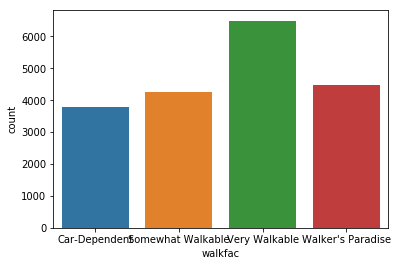

In [ ]:
df = df
df['walkfac'] = df.walkfac.astype('category')
sns.countplot(x='walkfac', data=df)

### Remove records with outlier/error values in assessed values (av1)

dropping those with negative assessed values (av1) (possible error or outlier)

In [ ]:
#dropping those with negative assessed values (av1) (possible error or outlier)
df2 = df

print(df2.shape)

df2 = df2[df2['av1']>=0]
print(df2.shape)
print(df2.av1.describe())

(19036, 92)
(18795, 92)
count     18795.000000
mean      31028.414153
std       27579.156992
min         285.000000
25%       15610.000000
50%       23846.000000
75%       37006.500000
max      763909.000000
Name: av1, dtype: float64


In [ ]:
df2.describe()

,av1,value,taxes,white,black,hispanic,asian,medhinc,poverty,college,...,Sub_Area_Code_29,Sub_Area_Code_30,Sub_Area_Code_31,Sub_Area_Code_32,Sub_Area_Code_33,Sub_Area_Code_34,Sub_Area_Code_35,Sub_Area_Code_36,race_White,ethnicity_Non-hispanic
count,18795.000000,1.879500e+04,18795.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,...,18795.000000,18795.000000,18795.000000,18795.000000,18795.000000,18795.000000,18795.000000,18795.000000,18795.000000,18795.000000
mean,31028.414153,3.582281e+05,5000.925224,0.628175,0.202515,0.186341,0.140107,67199.268994,0.133972,0.318884,...,0.038521,0.029689,0.040011,0.032296,0.030274,0.017132,0.016121,0.028305,0.747167,0.887576
std,27579.156992,3.651279e+05,4236.381074,0.273263,0.294183,0.214227,0.118598,26217.815930,0.098518,0.212141,...,0.192455,0.169732,0.195989,0.176789,0.171345,0.129767,0.125945,0.165848,0.434648,0.315895
min,285.000000,6.500000e+03,0.000000,0.001088,0.000789,0.001889,0.000000,9550.000000,0.003604,0.004178,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15610.000000,1.758500e+05,2504.325050,0.501052,0.020709,0.053359,0.054094,48099.000000,0.064112,0.136102,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,23846.000000,2.675000e+05,3963.659900,0.703805,0.050218,0.091340,0.099713,63750.000000,0.111513,0.265727,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,37006.500000,4.150000e+05,6112.679950,0.852830,0.252911,0.221132,0.195021,84223.000000,0.169830,0.507037,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,763909.000000,1.500000e+07,133258.690000,0.970822,0.993390,0.979010,0.896609,192143.000000,0.776376,0.766168,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


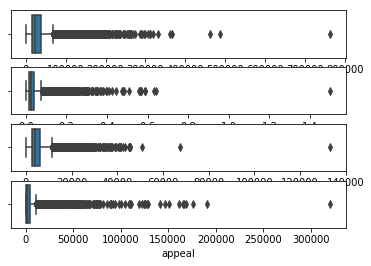

In [ ]:
#review distribution 

plt.subplot(4,1,1)
sns.boxplot(df2['av1'])

plt.subplot(4,1,2)
sns.boxplot(df2['value'])

plt.subplot(4,1,3)
sns.boxplot(df2['taxes'])

plt.subplot(4,1,4)
sns.boxplot(df2['appeal'])

# Running Basic Logit Regression Model with original values


## keep select numeric variables and dropping na

In [ ]:
categoricals

{'Area_Code',
 'Sub_Area_Code',
 'ethnicity',
 'pcity',
 'pdir',
 'pin14',
 'pstreet',
 'race',
 'tcity',
 'walkfac'}

In [ ]:
numericals

{'appeal',
 'appeal2',
 'appeal_success',
 'asian',
 'av1',
 'avg_school_score',
 'beds',
 'black',
 'college',
 'condo',
 'elem_score',
 'high_school_score',
 'hispanic',
 'homeowner',
 'medhinc',
 'poverty',
 'squarefoot',
 'tax_rate',
 'tax_rate2',
 'taxes',
 'tri',
 'value',
 'walkscore',
 'white'}

In [ ]:


df3 = df2[['av1','appeal2','tax_rate', 'tax_rate2','taxes','value',
          'white',	'black',	'hispanic',	'asian',
          'medhinc',	'poverty',
          'squarefoot',	'beds',	'walkscore',	
          'college','elem_score',	'high_school_score',	'avg_school_score',
          'condo_Non-condo','homeowner_1',
          'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]


df3 = df3.dropna()

df3.isna().sum()
df3.appeal2.value_counts()

0    7443
1    6268
Name: appeal2, dtype: int64

In [ ]:
df3['condo_Non-condo'].value_counts()

1    13711
Name: condo_Non-condo, dtype: int64

In [ ]:
df3.shape

(13711, 23)

## Run Logit model

## Model 1 - basic

In [ ]:
#import statsmodels.api as sm
#import numpy as np


#running a logit model with all original variables

#X = df3[['av1','homeowner',	'white',	'black',	'hispanic',	'asian',	'medhinc',	'poverty','college',	'squarefoot',	'beds',	'walkscore',	'elem_score',	'high_school_score',	'avg_school_score']]
X = df3[['av1',	'white',	'black',	'hispanic',	'asian',	'medhinc',	'poverty',
       'college',	'squarefoot',	'beds',	'walkscore',	'elem_score',	'high_school_score',	'avg_school_score',
       'condo_Non-condo','homeowner_1','tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]
#X = df.drop(['appeal2','pin14','pdir','pstreet','pcity','tcity','appeal'], axis=1)
y = df3['appeal2']

X = sm.add_constant(X)
#model1 = sm.Logit(y,X)
#result1 = model1.fit()
#result1.summary()

LModel = sm.Logit(y,X)
LResult = LModel.fit()

LResult.summary()

Optimization terminated successfully.
         Current function value: 0.629585
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                appeal2   No. Observations:                13711
Model:                          Logit   Df Residuals:                    13693
Method:                           MLE   Df Model:                           17
Date:                Mon, 11 May 2020   Pseudo R-squ.:                 0.08686
Time:                        05:08:48   Log-Likelihood:                -8632.2
converged:                       True   LL-Null:                       -9453.3
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
av1                                 2.026e-05    1.5e-06     13.509      0.000    1.73e-05    2.32e-05
white                                 -8.2914      2.016     -4.113      0.000     -12.243      -4.340
black                                 -8.4388      2.017     -4.184      0.000     -12.392      -4.486
hispanic                              -1.0272      0.185     -5.560      0.000      -1.389      -0.665
asian                                 -7.6284      2.096     -3.640      0.000     -11.736      -3.521
medhinc                            -3.969e-06   1.35e-06     -2.940      0.003   -6.61e-06   -1.32e-06
poverty                               -0.6369      0.284     -2.244      0.025      -1.193      -0.081
college                                0.7072      0.248      2.851      0.004       0.221       1.193
squarefoot                             0.0003    3.1e-05      8.362      0.000       0.000       0.000
beds                                  -0.0701      0.018     -3.800      0.000      -0.106      -0.034
walkscore                              0.0007      0.001      0.641      0.521      -0.002       0.003
elem_score                            -0.0241      0.041     -0.588      0.556      -0.104       0.056
high_school_score                     -0.0178      0.038     -0.467      0.640      -0.092       0.057
avg_school_score                       0.0506      0.076      0.663      0.507      -0.099       0.200
condo_Non-condo                        7.1348      1.981      3.601      0.000       3.252      11.018
homeowner_1                            0.2140      0.037      5.712      0.000       0.141       0.287
tri_Northwest Suburban Cook County    -0.1176      0.073     -1.620      0.105      -0.260       0.025
tri_Southwest Suburban Cook County     0.0487      0.053      0.925      0.355      -0.054       0.152
======================================================================================================
"""

In the basic model using original variables, we noticed almost all parameters (except walkscore, school related ratings and tri) had significant (p <0.05) impact on appeal.

### Prediction

[Text(0, 0.5, 'appeal'), Text(0.5, 0, 'av1')]

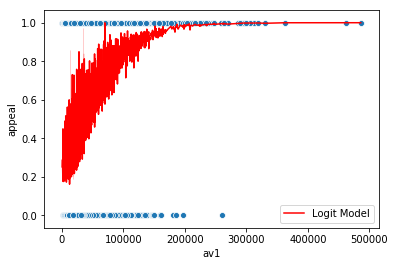

In [ ]:

predY = LResult.predict(X)

ax = sns.lineplot(x=df["av1"], y=predY, label="Logit Model", color="r")
sns.scatterplot(x=df["av1"], y=y)
ax.set(xlabel="av1", ylabel="appeal")

### Prediction Success rate

In [ ]:
logit_predicted_probabilities = LResult.predict()
logit_predicted_outcomes = []
for predicted_probability in logit_predicted_probabilities:
    if predicted_probability<.5:
        logit_predicted_outcomes.append(0)
    else:
        logit_predicted_outcomes.append(1)


logit_hits = 0
i = 0
for appeal2 in y:
    if logit_predicted_outcomes[i]==appeal2:
        logit_hits = logit_hits + 1
        i = i+1

logit_percent_correct = logit_hits/len(y)*100
print("The logit model got %f correct" % logit_percent_correct)

The logit model got 3.413318 correct


The percentage of correct predictions are quite low. This may be due to lower predicted probability and we may get better results by adjusting the threshold to a lower value than 0.5 for defining appeal as 1 ('YES').

## Model 2 Running Logit regression model with select variables

Running without 'tri' (found as insignificant above) and 'condo' (since these don't have beds and squarefoot information)

In [ ]:

#running a logit model with all original variables
df4 = df2[['appeal2','av1','homeowner_1',	'white',	'black',	'hispanic',	'asian',	'medhinc',	'poverty',
       'college',	'squarefoot',	'beds',	'walkscore',	'elem_score',	'high_school_score',	'avg_school_score','tax_rate2']]
df4 = df4.dropna()


X = df4[['av1','homeowner_1',	'white',	'black',	'hispanic',	'asian',	'medhinc',	'poverty',
       'college',	'squarefoot',	'beds',	'walkscore',	'elem_score',	'high_school_score',	'avg_school_score','tax_rate2']]
#X = df.drop(['appeal2','pin14','pdir','pstreet','pcity','tcity','appeal'], axis=1)
y = df4['appeal2']

X = sm.add_constant(X)
#model1 = sm.Logit(y,X)
#result1 = model1.fit()
#result1.summary()

LModel = sm.Logit(y,X)
LResult = LModel.fit()

LResult.summary()

Optimization terminated successfully.
         Current function value: 0.622184
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                appeal2   No. Observations:                13711
Model:                          Logit   Df Residuals:                    13694
Method:                           MLE   Df Model:                           16
Date:                Mon, 11 May 2020   Pseudo R-squ.:                 0.09759
Time:                        05:09:33   Log-Likelihood:                -8530.8
converged:                       True   LL-Null:                       -9453.3
                                        LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.2246      1.995      1.617      0.106      -0.685       7.134
av1                2.026e-05   1.49e-06     13.566      0.000    1.73e-05    2.32e-05
homeowner_1           0.2660      0.038      7.013      0.000       0.192       0.340
white                -5.1200      2.027     -2.526      0.012      -9.092      -1.148
black                -5.3484      2.027     -2.638      0.008      -9.322      -1.375
hispanic             -0.7848      0.178     -4.417      0.000      -1.133      -0.437
asian                -4.6654      2.113     -2.208      0.027      -8.807      -0.523
medhinc           -4.087e-06   1.35e-06     -3.024      0.002   -6.74e-06   -1.44e-06
poverty              -0.0883      0.284     -0.311      0.756      -0.645       0.468
college               0.8685      0.248      3.504      0.000       0.383       1.354
squarefoot            0.0003   3.12e-05      8.811      0.000       0.000       0.000
beds                 -0.0757      0.019     -4.087      0.000      -0.112      -0.039
walkscore             0.0028      0.001      2.480      0.013       0.001       0.005
elem_score            0.0199      0.041      0.483      0.629      -0.061       0.101
high_school_score     0.0131      0.038      0.343      0.732      -0.062       0.088
avg_school_score     -0.0040      0.077     -0.052      0.959      -0.154       0.146
tax_rate2             0.2660      0.019     14.227      0.000       0.229       0.303
=====================================================================================
"""

For most part the results didn't change compared to the first model.

### Prediction

[Text(0, 0.5, 'appeal2'), Text(0.5, 0, 'av1')]

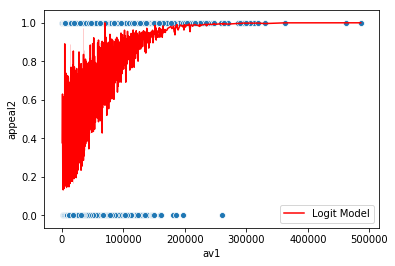

In [ ]:

predY = LResult.predict(X)

ax = sns.lineplot(x=df["av1"], y=predY, label="Logit Model", color="r")
sns.scatterplot(x=df["av1"], y=y)
ax.set(xlabel="av1", ylabel="appeal2")

### Prediction Performance

In [ ]:
logit_predicted_probabilities = LResult.predict()
logit_predicted_outcomes = []
for predicted_probability in logit_predicted_probabilities:
    if predicted_probability<.5:
        logit_predicted_outcomes.append(0)
    else:
        logit_predicted_outcomes.append(1)


logit_hits = 0
i = 0
for appeal2 in y:
    if logit_predicted_outcomes[i]==appeal2:
        logit_hits = logit_hits + 1
        i = i+1

logit_percent_correct = logit_hits/len(y)*100
print("The logit model got %f correct" % logit_percent_correct)

The logit model got 3.705054 correct


Still quite low percentage of correct predictions.

## Model 3 with select variables

In [ ]:
df3.shape

(13711, 23)

In [ ]:


#'tax_rate2','taxes'
#'elem_score',	'high_school_score',
#'squarefoot',	'beds',

X = df3[['av1','tax_rate','value',
          'white',	'black',	'hispanic',	'asian',
          'medhinc',	'poverty',
          'walkscore',	
          'college','avg_school_score',
          'condo_Non-condo','homeowner_1',
          'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]
#X = df.drop(['appeal2','pin14','pdir','pstreet','pcity','tcity','appeal'], axis=1)
y = df3['appeal2']

X = sm.add_constant(X)
#model1 = sm.Logit(y,X)
#result1 = model1.fit()
#result1.summary()

LModel = sm.Logit(y,X)
LResult = LModel.fit()

LResult.summary()

Optimization terminated successfully.
         Current function value: 0.624652
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                appeal2   No. Observations:                13711
Model:                          Logit   Df Residuals:                    13695
Method:                           MLE   Df Model:                           15
Date:                Mon, 11 May 2020   Pseudo R-squ.:                 0.09401
Time:                        05:10:17   Log-Likelihood:                -8564.6
converged:                       True   LL-Null:                       -9453.3
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
av1                                 4.728e-05   2.12e-06     22.345      0.000    4.31e-05    5.14e-05
tax_rate                               0.0127      0.002      5.712      0.000       0.008       0.017
value                              -1.893e-06   1.44e-07    -13.182      0.000   -2.17e-06   -1.61e-06
white                                 -5.6171      2.027     -2.771      0.006      -9.590      -1.644
black                                 -5.7787      2.028     -2.849      0.004      -9.754      -1.804
hispanic                              -0.9490      0.184     -5.147      0.000      -1.310      -0.588
asian                                 -4.9585      2.104     -2.357      0.018      -9.082      -0.834
medhinc                            -4.144e-06   1.37e-06     -3.032      0.002   -6.82e-06   -1.46e-06
poverty                               -0.2111      0.283     -0.746      0.456      -0.766       0.344
walkscore                              0.0002      0.001      0.200      0.841      -0.002       0.002
college                                0.9037      0.252      3.583      0.000       0.409       1.398
avg_school_score                       0.0141      0.012      1.176      0.240      -0.009       0.038
condo_Non-condo                        4.3379      1.995      2.174      0.030       0.428       8.248
homeowner_1                            0.2173      0.038      5.737      0.000       0.143       0.291
tri_Northwest Suburban Cook County    -0.2366      0.074     -3.184      0.001      -0.382      -0.091
tri_Southwest Suburban Cook County    -0.0788      0.057     -1.380      0.168      -0.191       0.033
======================================================================================================
"""

### Prediction

[Text(0, 0.5, 'appeal2'), Text(0.5, 0, 'av1')]

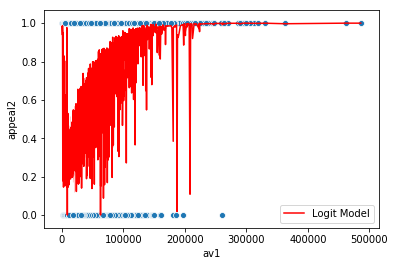

In [ ]:
predY = LResult.predict(X)

ax = sns.lineplot(x=df["av1"], y=predY, label="Logit Model", color="r")
sns.scatterplot(x=df["av1"], y=y)
ax.set(xlabel="av1", ylabel="appeal2")

### Prediction Performance

In [ ]:
logit_predicted_probabilities = LResult.predict()
logit_predicted_outcomes = []
for predicted_probability in logit_predicted_probabilities:
    if predicted_probability<.5:
        logit_predicted_outcomes.append(0)
    else:
        logit_predicted_outcomes.append(1)


logit_hits = 0
i = 0
for appeal2 in y:
    if logit_predicted_outcomes[i]==appeal2:
        logit_hits = logit_hits + 1
        i = i+1

logit_percent_correct = logit_hits/len(y)*100
print("The logit model got %f correct" % logit_percent_correct)

The logit model got 3.500839 correct


## Model 4 -without square foot & bed, but keep condo

In [ ]:
df5 = df

df5 = df[['av1','appeal2','taxes',	'white',	'black',	'hispanic',	'asian',	'medhinc',	'poverty',
       'college',	'walkscore',	'elem_score',	'high_school_score',	'avg_school_score',
       'condo_Non-condo','homeowner_1','tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]
df5 = df5.dropna()

df5.shape

(18869, 18)

### Log transformation of av1

In [ ]:
df5 = df5[df5['av1']>0]

In [ ]:
df5['log_av1'] = np.log(df5.av1)

In [ ]:
df5.shape

(18677, 19)

In [ ]:
df5.describe()

,av1,appeal2,taxes,white,black,hispanic,asian,medhinc,poverty,college,walkscore,elem_score,high_school_score,avg_school_score,condo_Non-condo,homeowner_1,tri_Northwest Suburban Cook County,tri_Southwest Suburban Cook County,log_av1
count,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000,18677.000000
mean,31050.361621,0.467688,5009.633179,0.628175,0.202515,0.186341,0.140107,67199.268994,0.133972,0.318884,69.622156,5.464529,5.413289,5.658510,0.739733,0.431226,0.073674,0.329068,10.085191
std,27554.945086,0.498968,4230.815149,0.273263,0.294183,0.214227,0.118598,26217.815930,0.098518,0.212141,23.563661,2.403099,2.868642,2.223966,0.438792,0.495261,0.261246,0.469887,0.720462
min,285.000000,0.000000,0.000000,0.001088,0.000789,0.001889,0.000000,9550.000000,0.003604,0.004178,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.652489
25%,15630.000000,0.000000,2516.540000,0.501052,0.020709,0.053359,0.054094,48099.000000,0.064112,0.136102,55.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,9.656947
50%,23879.000000,0.000000,3972.480000,0.703805,0.050218,0.091340,0.099713,63750.000000,0.111513,0.265727,75.000000,6.000000,5.000000,6.000000,1.000000,0.000000,0.000000,0.000000,10.080755
75%,37061.000000,1.000000,6122.339800,0.852830,0.252911,0.221132,0.195021,84223.000000,0.169830,0.507037,89.000000,7.000000,8.000000,7.000000,1.000000,1.000000,0.000000,1.000000,10.520320
max,763909.000000,1.000000,133258.690000,0.970822,0.993390,0.979010,0.896609,192143.000000,0.776376,0.766168,100.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,13.546204


#### Keeping only positive taxes records

In [ ]:
df5 = df5[df5['taxes']>0]
df5.shape

(18615, 19)

#### using log_av1

In [ ]:
#'elem_score',	'high_school_score',

X = df5[['log_av1',	'white',	'black',	'hispanic',	'asian',	'medhinc',	'poverty',
       'college',	'walkscore',		'avg_school_score',
       'condo_Non-condo','homeowner_1','tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]
#X = df.drop(['appeal2','pin14','pdir','pstreet','pcity','tcity','appeal'], axis=1)
y = df5['appeal2']

X = sm.add_constant(X)
#model1 = sm.Logit(y,X)
#result1 = model1.fit()
#result1.summary()

LModel = sm.Logit(y,X)
LResult = LModel.fit()

LResult.summary()

Optimization terminated successfully.
         Current function value: 0.651090
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                appeal2   No. Observations:                18615
Model:                          Logit   Df Residuals:                    18600
Method:                           MLE   Df Model:                           14
Date:                Mon, 11 May 2020   Pseudo R-squ.:                 0.05783
Time:                        05:11:01   Log-Likelihood:                -12120.
converged:                       True   LL-Null:                       -12864.
                                        LLR p-value:                2.069e-309
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.7589      1.724     -0.440      0.660      -4.138       2.620
log_av1                                0.4172      0.029     14.542      0.000       0.361       0.473
white                                 -4.3672      1.710     -2.553      0.011      -7.720      -1.015
black                                 -4.4309      1.713     -2.587      0.010      -7.788      -1.074
hispanic                              -1.3867      0.159     -8.703      0.000      -1.699      -1.074
asian                                 -2.6719      1.784     -1.498      0.134      -6.168       0.824
medhinc                            -4.425e-06   1.04e-06     -4.236      0.000   -6.47e-06   -2.38e-06
poverty                               -0.3623      0.246     -1.471      0.141      -0.845       0.120
college                                1.9221      0.181     10.614      0.000       1.567       2.277
walkscore                           9.077e-05      0.001      0.084      0.933      -0.002       0.002
avg_school_score                       0.0072      0.010      0.699      0.484      -0.013       0.027
condo_Non-condo                        0.4849      0.055      8.811      0.000       0.377       0.593
homeowner_1                            0.0681      0.032      2.156      0.031       0.006       0.130
tri_Northwest Suburban Cook County    -0.2741      0.069     -3.954      0.000      -0.410      -0.138
tri_Southwest Suburban Cook County     0.0134      0.050      0.268      0.788      -0.084       0.111
======================================================================================================
"""

##### Prediction

[Text(0, 0.5, 'appeal2'), Text(0.5, 0, 'log_av1')]

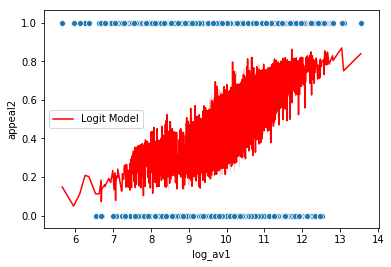

In [ ]:
#with log_av1
predY = LResult.predict(X)

ax = sns.lineplot(x=df5["log_av1"], y=predY, label="Logit Model", color="r")
sns.scatterplot(x=df5["log_av1"], y=y)
ax.set(xlabel="log_av1", ylabel="appeal2")

##### Prediction Performance

In [ ]:
logit_predicted_probabilities = LResult.predict()
logit_predicted_outcomes = []
for predicted_probability in logit_predicted_probabilities:
    if predicted_probability<.5:
        logit_predicted_outcomes.append(0)
    else:
        logit_predicted_outcomes.append(1)


logit_hits = 0
i = 0
for appeal2 in y:
    if logit_predicted_outcomes[i]==appeal2:
        logit_hits = logit_hits + 1
        i = i+1

logit_percent_correct = logit_hits/len(y)*100
print("The logit model got %f correct" % logit_percent_correct)

The logit model got 17.620199 correct


By using log_av1, our correct prediction rate increased significantly.

### using av1

In [ ]:
#with av1

#'elem_score',	'high_school_score',

X = df5[['av1',	'white',	'black',	'hispanic',	'asian',	'medhinc',	'poverty',
       'college',	'walkscore',		'avg_school_score',
       'condo_Non-condo','homeowner_1','tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]
#X = df.drop(['appeal2','pin14','pdir','pstreet','pcity','tcity','appeal'], axis=1)
y = df5['appeal2']

X = sm.add_constant(X)
#model1 = sm.Logit(y,X)
#result1 = model1.fit()
#result1.summary()

LModel = sm.Logit(y,X)
LResult = LModel.fit()

LResult.summary()

Optimization terminated successfully.
         Current function value: 0.646135
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                appeal2   No. Observations:                18615
Model:                          Logit   Df Residuals:                    18600
Method:                           MLE   Df Model:                           14
Date:                Mon, 11 May 2020   Pseudo R-squ.:                 0.06500
Time:                        05:12:12   Log-Likelihood:                -12028.
converged:                       True   LL-Null:                       -12864.
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  3.5965      1.684      2.135      0.033       0.295       6.898
av1                                 1.753e-05   9.75e-07     17.972      0.000    1.56e-05    1.94e-05
white                                 -4.7269      1.710     -2.764      0.006      -8.078      -1.375
black                                 -4.7873      1.711     -2.797      0.005      -8.142      -1.433
hispanic                              -1.3761      0.159     -8.641      0.000      -1.688      -1.064
asian                                 -2.9640      1.783     -1.662      0.096      -6.459       0.531
medhinc                            -5.578e-06   1.06e-06     -5.242      0.000   -7.66e-06   -3.49e-06
poverty                               -0.7017      0.249     -2.821      0.005      -1.189      -0.214
college                                1.6314      0.183      8.899      0.000       1.272       1.991
walkscore                             -0.0005      0.001     -0.427      0.669      -0.003       0.002
avg_school_score                       0.0070      0.010      0.677      0.499      -0.013       0.027
condo_Non-condo                        0.3573      0.056      6.392      0.000       0.248       0.467
homeowner_1                            0.0835      0.032      2.635      0.008       0.021       0.146
tri_Northwest Suburban Cook County    -0.2366      0.070     -3.392      0.001      -0.373      -0.100
tri_Southwest Suburban Cook County     0.0333      0.050      0.670      0.503      -0.064       0.131
======================================================================================================
"""

##### Prediction

[Text(0, 0.5, 'appeal2'), Text(0.5, 0, 'av1')]

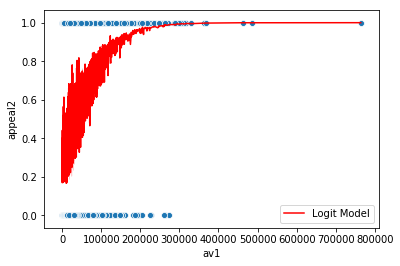

In [ ]:
#with av1
predY = LResult.predict(X)

ax = sns.lineplot(x=df5["av1"], y=predY, label="Logit Model", color="r")
sns.scatterplot(x=df5["av1"], y=y)
ax.set(xlabel="av1", ylabel="appeal2")

##### Prediction Performance

In [ ]:
logit_predicted_probabilities = LResult.predict()
logit_predicted_outcomes = []
for predicted_probability in logit_predicted_probabilities:
    if predicted_probability<.5:
        logit_predicted_outcomes.append(0)
    else:
        logit_predicted_outcomes.append(1)


logit_hits = 0
i = 0
for appeal2 in y:
    if logit_predicted_outcomes[i]==appeal2:
        logit_hits = logit_hits + 1
        i = i+1

logit_percent_correct = logit_hits/len(y)*100
print("The logit model got %f correct" % logit_percent_correct)

The logit model got 18.184260 correct


## Model 5

#### using av1

In [ ]:
#df6 = df

df6 = df[['appeal2','av1','taxes',
         'race_White','ethnicity_Non-hispanic',	
         'medhinc',	'poverty',
         'college',	'avg_school_score','walkscore',
         'condo_Non-condo','homeowner_1',
         'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]
df6 = df6.dropna()

df6.shape

(18869, 14)

In [ ]:
#with av1
#'elem_score',	'high_school_score',

X = df6[['av1', 'taxes',
         'race_White','ethnicity_Non-hispanic',	
         'medhinc',	'poverty',
         'college',	'avg_school_score','walkscore',
         'condo_Non-condo','homeowner_1',
         'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]
#X = df.drop(['appeal2','pin14','pdir','pstreet','pcity','tcity','appeal'], axis=1)
y = df6['appeal2']

X = sm.add_constant(X)

LModel = sm.Logit(y,X)
LResult = LModel.fit()

LResult.summary()

Optimization terminated successfully.
         Current function value: 0.655858
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                appeal2   No. Observations:                18869
Model:                          Logit   Df Residuals:                    18855
Method:                           MLE   Df Model:                           13
Date:                Mon, 11 May 2020   Pseudo R-squ.:                 0.05182
Time:                        05:13:21   Log-Likelihood:                -12375.
converged:                       True   LL-Null:                       -13052.
                                        LLR p-value:                2.482e-281
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.4183      0.133    -10.631      0.000      -1.680      -1.157
av1                                   8.5e-06   1.29e-06      6.596      0.000    5.97e-06     1.1e-05
taxes                               2.037e-05   8.07e-06      2.524      0.012    4.55e-06    3.62e-05
race_White                             0.0742      0.048      1.534      0.125      -0.021       0.169
ethnicity_Non-hispanic                 0.1450      0.058      2.480      0.013       0.030       0.260
medhinc                             -5.81e-06   1.04e-06     -5.589      0.000   -7.85e-06   -3.77e-06
poverty                               -0.1222      0.237     -0.515      0.607      -0.588       0.343
college                                2.2808      0.165     13.814      0.000       1.957       2.604
avg_school_score                       0.0161      0.009      1.769      0.077      -0.002       0.034
walkscore                             -0.0001      0.001     -0.125      0.900      -0.002       0.002
condo_Non-condo                        0.5028      0.054      9.383      0.000       0.398       0.608
homeowner_1                            0.0688      0.031      2.196      0.028       0.007       0.130
tri_Northwest Suburban Cook County    -0.1215      0.067     -1.812      0.070      -0.253       0.010
tri_Southwest Suburban Cook County    -0.0712      0.050     -1.412      0.158      -0.170       0.028
======================================================================================================
"""

After trasforming and keeping select variables, we found most of our selected variables are significant (p<0.05). 

##### Prediction

[Text(0, 0.5, 'appeal2'), Text(0.5, 0, 'av1')]

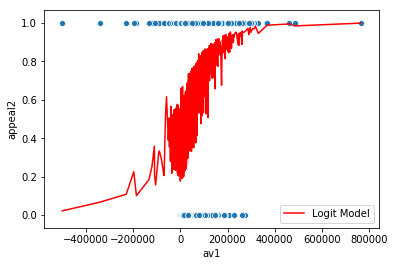

In [ ]:
predY = LResult.predict(X)

ax = sns.lineplot(x=df6["av1"], y=predY, label="Logit Model", color="r")
sns.scatterplot(x=df6["av1"], y=y)
ax.set(xlabel="av1", ylabel="appeal2")

##### Prediction Performance

In [ ]:
logit_predicted_probabilities = LResult.predict()
logit_predicted_outcomes = []
for predicted_probability in logit_predicted_probabilities:
    if predicted_probability<.5:
        logit_predicted_outcomes.append(0)
    else:
        logit_predicted_outcomes.append(1)


logit_hits = 0
i = 0
for appeal2 in y:
    if logit_predicted_outcomes[i]==appeal2:
        logit_hits = logit_hits + 1
        i = i+1

logit_percent_correct = logit_hits/len(y)*100
print("The logit model got %f correct" % logit_percent_correct)

The logit model got 17.600297 correct


# Wald Test for Logit model 

To test whether keeping the parameters in model improves the model. So our null hypothesis is that the coefficient of the parameters in model are equal to zero.

In [ ]:
R = np.eye(len(LResult.params))
LResult.wald_test(R)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[1237.11444699]], p-value=1.8162858213444093e-255, df_denom=14>

Interpretation: Since the p-value is significant, we can reject the null hypothese that all coefficients for the parameters are simulatenously equal to zero. In other words, keeping the parameters significantly improves the model and hence we kept the parameters in the model.

# Part 2: What influences how much money one might gain from a successful appeal?

## Data Cleaning/Remove Outlier

### Subset to successful appeal

In [ ]:
dt = df.loc[df['appeal_success'] == 1]
dt.shape
#df.loc[df['column_name'] == some_value]

(5587, 92)

In [ ]:
dt['condo_Non-condo'].value_counts()

1    3831
0    1756
Name: condo_Non-condo, dtype: int64

In [ ]:
dt['homeowner_1'].value_counts()

0    3187
1    2400
Name: homeowner_1, dtype: int64

### Check for negative assessed values

In [ ]:
dt.av1.describe()

count    5.587000e+03
mean     3.800949e+04
std      4.236777e+04
min     -1.045572e+06
25%      1.845400e+04
50%      2.957100e+04
75%      4.898550e+04
max      7.639090e+05
Name: av1, dtype: float64

### Drop negative av1

In [ ]:
dt = dt.loc[dt['av1']>0]
dt.shape

(5391, 92)

### Drop negative taxes

In [ ]:
dt = dt.loc[dt['taxes']>0]
dt.shape

(5369, 92)

### Drop appeal > taxes

In [ ]:
dt = dt.loc[dt['appeal']<dt['taxes']]
dt.shape

(3559, 92)

### Drop appeal > av1

In [ ]:
dt = dt.loc[dt['appeal']<dt['av1']]
dt.shape

(3558, 92)

### Calculate percentage reduction in assessed value

In [ ]:
dt['red_amt_per'] = dt['appeal']/dt['av1']*100

dt.red_amt_per.describe()
#dt.head()


count    3558.000000
mean        7.795550
std         4.755462
min         0.002051
25%         4.343004
50%         6.998454
75%        10.409213
max        98.660714
Name: red_amt_per, dtype: float64

#CHECKPOINT DT2 data set

#### Drop reduction per less than 1

In [ ]:
dt2 = dt
dt2 = dt2.loc[dt2['red_amt_per']>1]

dt2.shape

(3524, 93)

#### Log transformation of reduction amount percent

In [ ]:
dt2['log_red_amt_per']=np.log(dt2.red_amt_per)

#dt2['log_red_amt_per'].describe()
dt2.shape

(3524, 94)

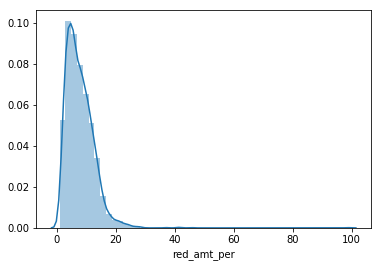

In [ ]:
sns.distplot(dt2['red_amt_per']) 
#dt2['red_amt_per'][dt2.red_amt_per > 100].hist(bins=500)

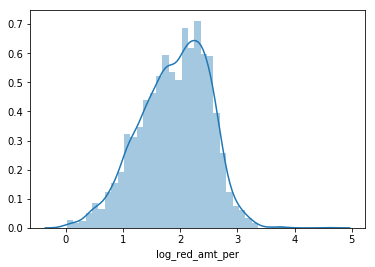

In [ ]:
#log of reduction amout
#np.log(dt['red_amt_per']).hist(bins=100)
#dt2['log_red_amt_per'].hist(bins=100)
sns.distplot(dt2['log_red_amt_per'])

### Calculate percentage reduction using 'value' (last sold value)

In [ ]:
dt2['red_amt_per2'] = dt2['appeal']/dt2['value'] *100

dt2.red_amt_per2.describe()
#dt.head()


count    3524.000000
mean        0.806789
std         0.600699
min         0.017127
25%         0.392183
50%         0.656914
75%         1.053536
max         6.557333
Name: red_amt_per2, dtype: float64

Drop reduction amount = or < 0

In [ ]:
dt2 = dt2[dt2['red_amt_per2'] >0]
dt2.shape

(3524, 95)

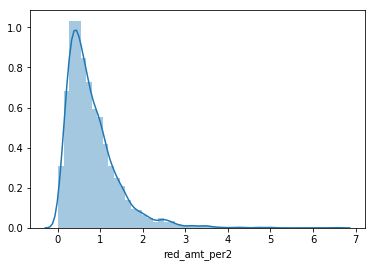

In [ ]:
sns.distplot(dt2['red_amt_per2'])

#### log transform reduction per calculated based on value

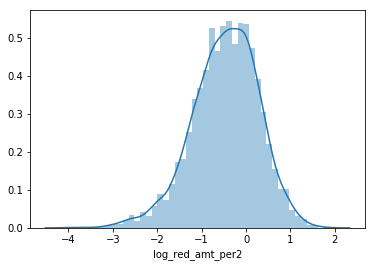

In [ ]:
dt2['log_red_amt_per2']=np.log(dt2.red_amt_per2)

sns.distplot(dt2['log_red_amt_per2'])

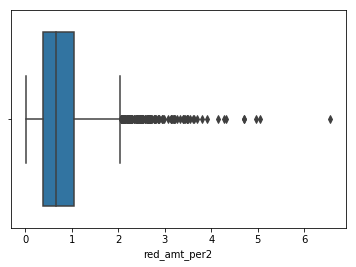

In [ ]:
sns.boxplot(dt2.red_amt_per2)

In [ ]:
dt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3524 entries, 2 to 19035
Data columns (total 96 columns):
pin14                                 3524 non-null category
pdir                                  2472 non-null category
pstreet                               3524 non-null category
pcity                                 3524 non-null category
tcity                                 3524 non-null category
av1                                   3524 non-null float64
value                                 3524 non-null int64
taxes                                 3524 non-null float64
white                                 3499 non-null float64
black                                 3499 non-null float64
hispanic                              3499 non-null float64
asian                                 3499 non-null float64
medhinc                               3499 non-null float64
poverty                               3499 non-null float64
college                               3499 non-nu

## Correlation Plot

In [ ]:
numericals3= ['appeal', 'asian', 'av1', 'avg_school_score', 'beds', 'black', 'college', 'condo_Non-condo',
               'elem_score', 'high_school_score', 'hispanic', 'homeowner_1', 'medhinc', 'poverty', 'squarefoot', 'tax_rate',
               'tax_rate2', 'taxes', 'tri_Northwest Suburban Cook County', 'tri_Southwest Suburban Cook County', 'value', 'walkscore', 'white']

numericals3

['appeal',
 'asian',
 'av1',
 'avg_school_score',
 'beds',
 'black',
 'college',
 'condo_Non-condo',
 'elem_score',
 'high_school_score',
 'hispanic',
 'homeowner_1',
 'medhinc',
 'poverty',
 'squarefoot',
 'tax_rate',
 'tax_rate2',
 'taxes',
 'tri_Northwest Suburban Cook County',
 'tri_Southwest Suburban Cook County',
 'value',
 'walkscore',
 'white']

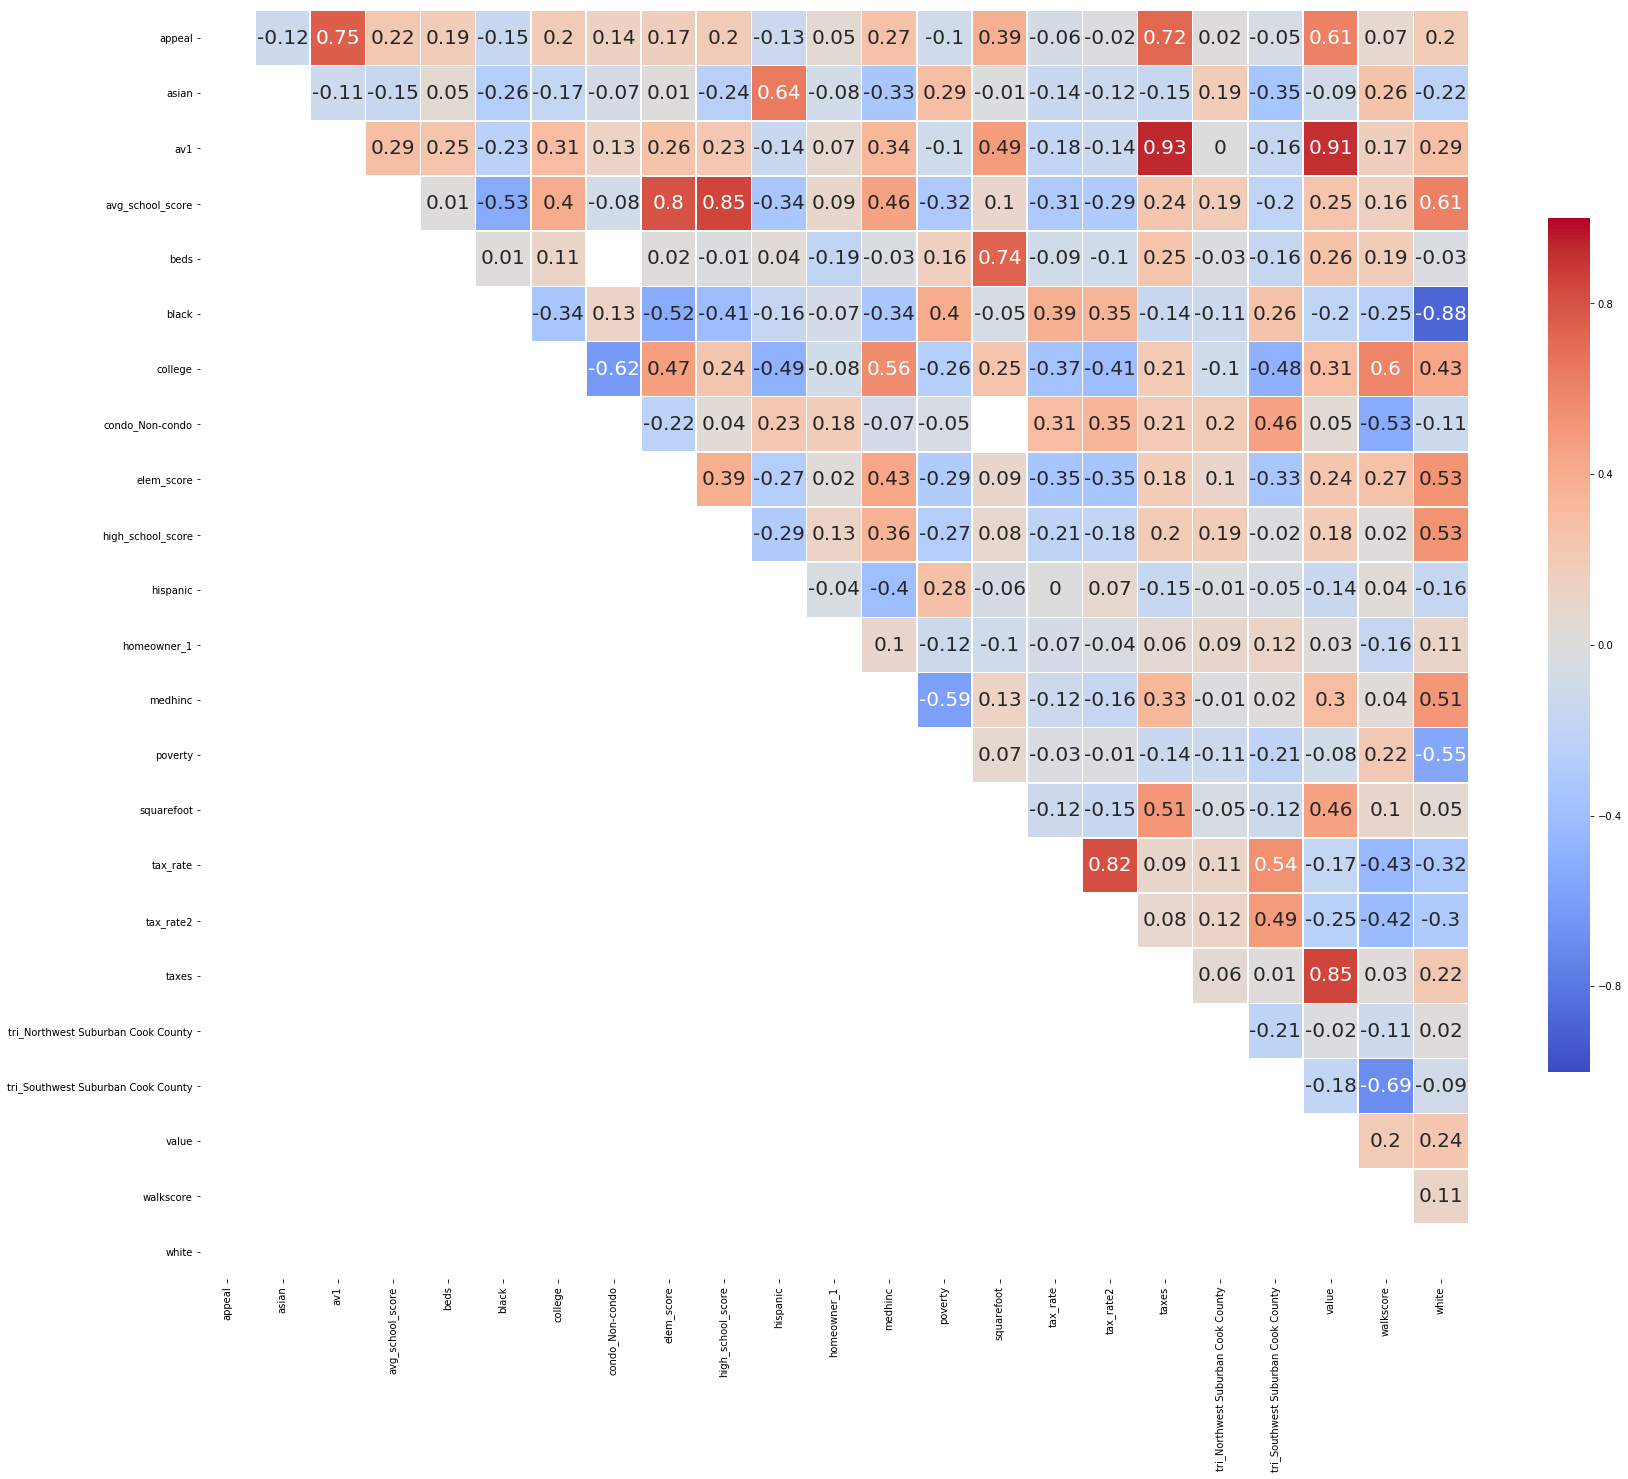

In [ ]:
corr2 = dt2[numericals3].corr()
fig, ax = plt.subplots(figsize=(25, 25))
corr_plot(ax, corr2, labels=numericals, triangle=True, upper=True, partial=True)
fig.tight_layout()

Interpretation: Lots of strong correlation (e.g., av1 and taxes positively correlated; avg school rating, elem school and high school ratings are positively correlated; black and white are negatively correlated; appeal and av1 are positively correlated).

## Create Dummies for walkFac

In [ ]:
dt2 = pd.get_dummies(data=dt2, columns=['walkfac'],drop_first=True)
dt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3524 entries, 2 to 19035
Data columns (total 98 columns):
pin14                                 3524 non-null category
pdir                                  2472 non-null category
pstreet                               3524 non-null category
pcity                                 3524 non-null category
tcity                                 3524 non-null category
av1                                   3524 non-null float64
value                                 3524 non-null int64
taxes                                 3524 non-null float64
white                                 3499 non-null float64
black                                 3499 non-null float64
hispanic                              3499 non-null float64
asian                                 3499 non-null float64
medhinc                               3499 non-null float64
poverty                               3499 non-null float64
college                               3499 non-nu

## Log Trasnformation

Log of Appeal

In [ ]:
dt2['log_appeal'] = np.log(dt2['appeal'])
dt2.shape

(3524, 99)

Log of av1

In [ ]:
dt2['log_av1'] = np.log(dt2['av1'])
dt2.shape

(3524, 100)

Log of value

In [ ]:
dt2['log_value'] = np.log(dt2['value'])
dt2.shape

(3524, 101)

Log of Taxes

In [ ]:
dt2['log_taxes'] = np.log(dt2['taxes'])
dt2.shape

(3524, 102)

Log of median household income

In [ ]:
dt2['log_medhinc'] = np.log(dt2['medhinc'])
dt2.shape

(3524, 103)

In [ ]:
dt2['log_poverty'] = np.log(dt2['poverty'])
dt2.shape

(3524, 104)

Distribution Plot to check for normal distribution

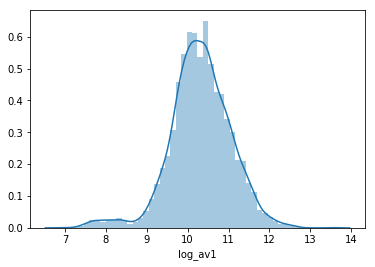

In [ ]:
sns.distplot(dt2.log_av1)

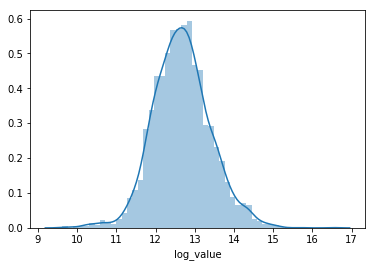

In [ ]:
sns.distplot(dt2.log_value)

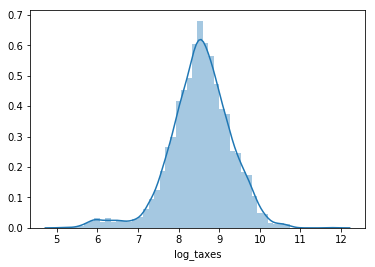

In [ ]:
sns.distplot(dt2.log_taxes)

Note: All the log transformed variables are now appearing to be normally distributed.

## Model Diagnostic Codes (to be used later)

### linearity_test

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
#linearity_test(model1, y) 

#reference: https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0


### homoscedasticity_test

In [ ]:
#Homoscedasticity (equal variance) of residuals
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

#homoscedasticity_test(lin_reg)


#significant p-value, so we reject the null hypothesis of equal variance or homoscedasticity

### normality_of_residuals_test

In [ ]:
#Normality of residuals
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
#normality_of_residuals_test(lin_reg)


#Potential solution - transform target variable (non-linear transformation), check & remove outliers,

## Reference Linear Model 1 -basic


#### using appeal

In [ ]:
model1 = sm1.ols(formula="appeal ~ av1 + taxes + white + black + hispanic +  asian +  medhinc + poverty + college + walkscore + elem_score +  high_school_score + avg_school_score", data=dt2) 
res1 = model1.fit()
res1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 appeal   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     345.7
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        05:17:46   Log-Likelihood:                -31673.
No. Observations:                3499   AIC:                         6.337e+04
Df Residuals:                    3485   BIC:                         6.346e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3857.6232   4053.143     -0.952      0.341   -1.18e+04    4089.150
av1                   0.0574      0.003     17.994      0.000       0.051       0.064
taxes                 0.0703      0.019      3.675      0.000       0.033       0.108
white              4378.9512   4099.705      1.068      0.286   -3659.114    1.24e+04
black              4423.0979   4127.768      1.072      0.284   -3669.990    1.25e+04
hispanic           -289.9470    392.735     -0.738      0.460   -1059.961     480.067
asian              4855.9774   4261.955      1.139      0.255   -3500.202    1.32e+04
medhinc               0.0016      0.002      0.782      0.434      -0.002       0.006
poverty            -108.1182    638.344     -0.169      0.866   -1359.684    1143.448
college             -13.0674    353.350     -0.037      0.971    -705.861     679.726
walkscore            -3.9028      2.388     -1.634      0.102      -8.585       0.780
elem_score         -206.1364     84.681     -2.434      0.015    -372.165     -40.108
high_school_score  -124.1702     76.453     -1.624      0.104    -274.068      25.728
avg_school_score    317.9154    152.711      2.082      0.037      18.504     617.327
==============================================================================
Omnibus:                     1096.036   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117143.872
Skew:                           0.445   Prob(JB):                         0.00
Kurtosis:                      31.332   Cond. No.                     2.15e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### using log_appeal

In [ ]:
model2 = sm1.ols(formula="log_appeal ~ av1 + taxes + white + black + hispanic +  asian +  medhinc + poverty + college + walkscore + elem_score +  high_school_score + avg_school_score", data=dt2) 
res2 = model2.fit()
res2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_appeal   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     201.4
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        05:17:56   Log-Likelihood:                -3629.3
No. Observations:                3499   AIC:                             7287.
Df Residuals:                    3485   BIC:                             7373.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.6612      1.340      7.958      0.000       8.034      13.288
av1                1.112e-05   1.05e-06     10.559      0.000    9.06e-06    1.32e-05
taxes              3.353e-05   6.32e-06      5.302      0.000    2.11e-05    4.59e-05
white                -3.8386      1.355     -2.833      0.005      -6.496      -1.182
black                -4.0394      1.364     -2.961      0.003      -6.715      -1.364
hispanic             -0.1382      0.130     -1.064      0.287      -0.393       0.116
asian                -3.8148      1.409     -2.708      0.007      -6.577      -1.053
medhinc            2.821e-06   6.87e-07      4.103      0.000    1.47e-06    4.17e-06
poverty               0.1989      0.211      0.942      0.346      -0.215       0.613
college              -0.2476      0.117     -2.120      0.034      -0.477      -0.019
walkscore            -0.0025      0.001     -3.144      0.002      -0.004      -0.001
elem_score           -0.0363      0.028     -1.295      0.195      -0.091       0.019
high_school_score    -0.0170      0.025     -0.672      0.501      -0.067       0.033
avg_school_score      0.0673      0.050      1.333      0.183      -0.032       0.166
==============================================================================
Omnibus:                     1325.522   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21751.051
Skew:                          -1.360   Prob(JB):                         0.00
Kurtosis:                      14.908   Cond. No.                     2.15e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Linear Model 1 - Basic org vars

In [ ]:
dt3 = dt2[['appeal','av1',	'white',	'black',	'hispanic',	'asian',	'medhinc',	'poverty',
       'college',	'walkscore',	'elem_score',	'high_school_score',	'avg_school_score','condo_Non-condo','homeowner_1',
       'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]
#X = df.drop(['appeal2','pin14','pdir','pstreet','pcity','tcity','appeal'], axis=1)
dt3.dropna(inplace=True)
dt3.shape


(3499, 17)

In [ ]:
Xl = dt3[['av1',	'white',	'black',	'hispanic',	'asian',	'medhinc',	'poverty',
       'college',	'walkscore',	'elem_score',	'high_school_score',	'avg_school_score','condo_Non-condo','homeowner_1',
       'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County']]

Xl.dropna(inplace=True)

yl = dt3['appeal']


#Xl = dt2[['av1']]
#yl = dt2['appeal']

Xl_constant = sm.add_constant(Xl)

#dt3.isna().sum()

lin_reg = sm.OLS(yl,Xl_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 appeal   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     281.7
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        05:18:04   Log-Likelihood:                -31669.
No. Observations:                3499   AIC:                         6.337e+04
Df Residuals:                    3482   BIC:                         6.348e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                              -3703.6422   4104.141     -0.902      0.367   -1.18e+04    4343.124
av1                                    0.0685      0.001     55.762      0.000       0.066       0.071
white                               3678.2400   4138.344      0.889      0.374   -4435.586    1.18e+04
black                               3754.3107   4167.046      0.901      0.368   -4415.789    1.19e+04
hispanic                            -238.9299    403.121     -0.593      0.553   -1029.306     551.447
asian                               4397.9067   4294.894      1.024      0.306   -4022.858    1.28e+04
medhinc                                0.0007      0.002      0.327      0.744      -0.004       0.005
poverty                              153.8946    649.395      0.237      0.813   -1119.338    1427.128
college                              434.2799    413.576      1.050      0.294    -376.596    1245.155
walkscore                             -1.5815      2.520     -0.628      0.530      -6.523       3.360
elem_score                          -228.7823     84.752     -2.699      0.007    -394.950     -62.615
high_school_score                   -160.6036     76.652     -2.095      0.036    -310.890     -10.317
avg_school_score                     380.2254    153.374      2.479      0.013      79.513     680.938
condo_Non-condo                       58.9826    122.899      0.480      0.631    -181.979     299.945
homeowner_1                         -125.4806     72.582     -1.729      0.084    -267.789      16.828
tri_Northwest Suburban Cook County   315.7126    153.875      2.052      0.040      14.017     617.408
tri_Southwest Suburban Cook County   521.0249    126.755      4.110      0.000     272.504     769.546
==============================================================================
Omnibus:                     1111.803   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106844.131
Skew:                           0.514   Prob(JB):                         0.00
Kurtosis:                      30.052   Cond. No.                     2.17e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Assumption check

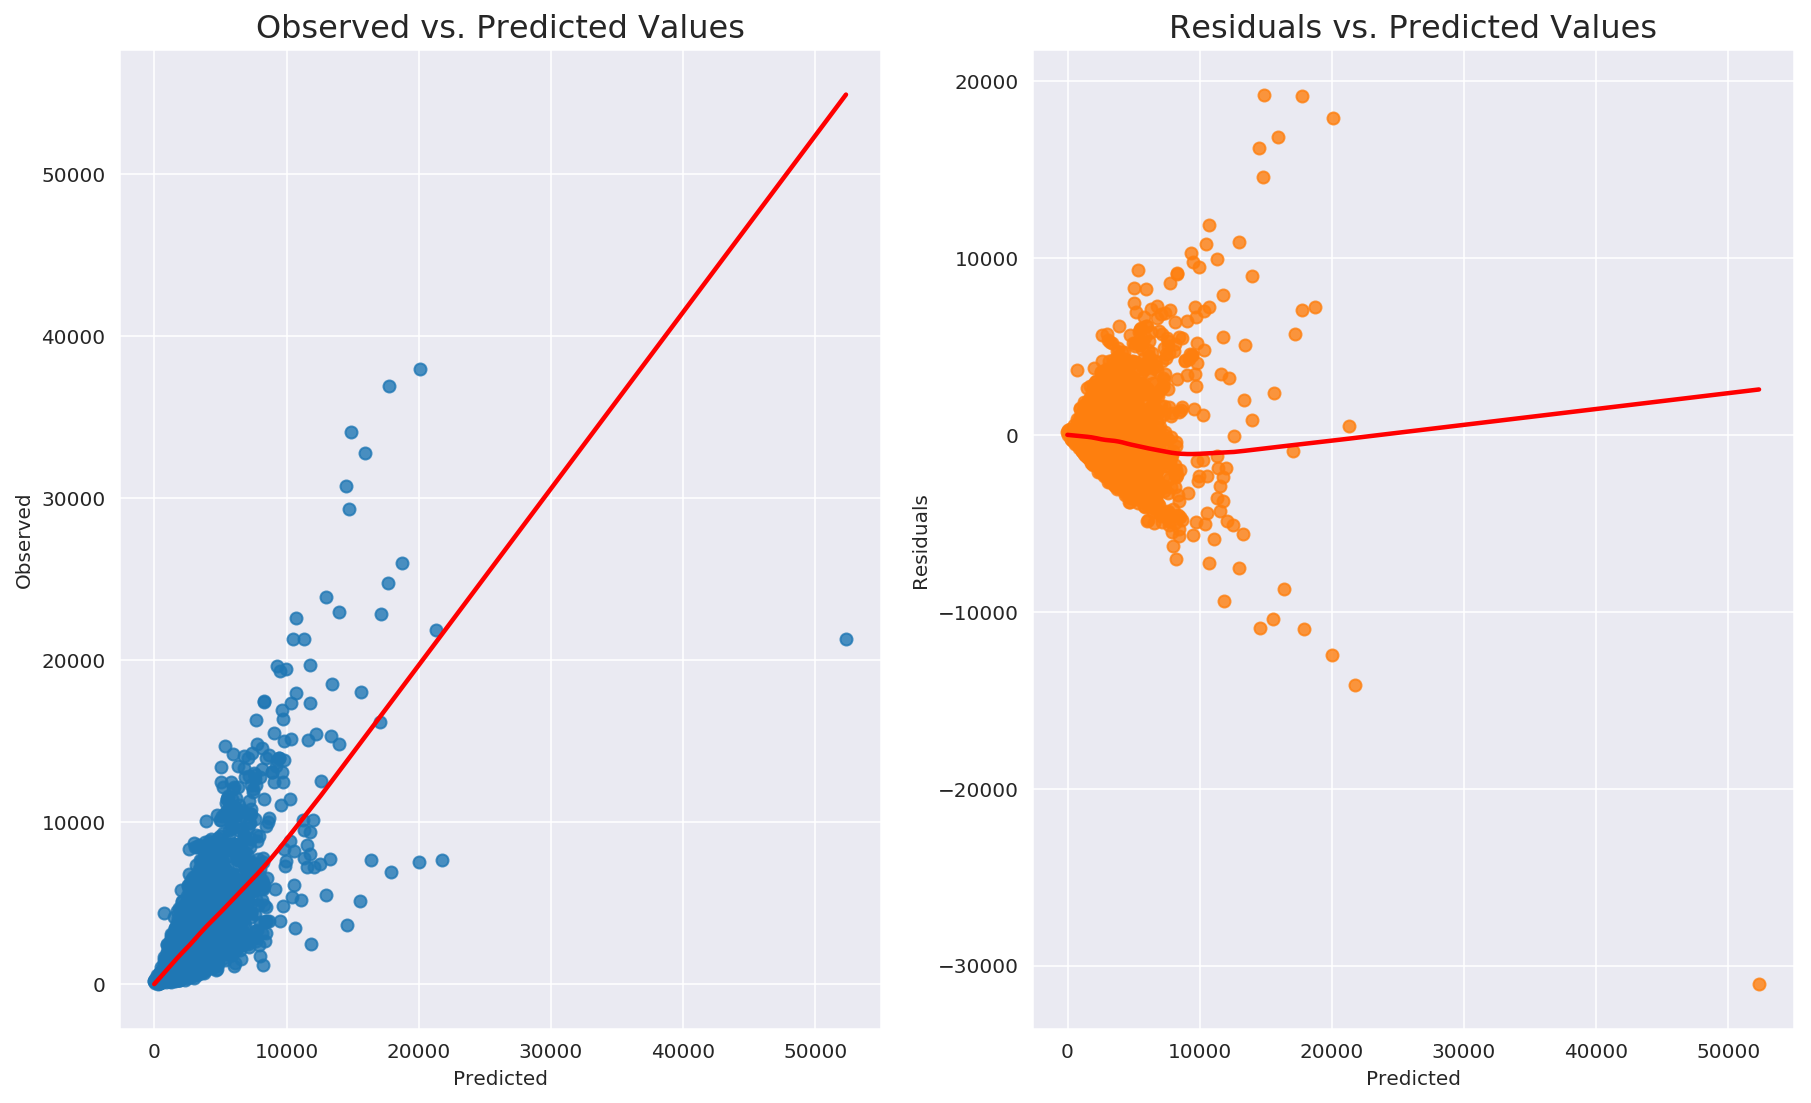

In [ ]:
linearity_test(lin_reg, yl) 

### multicollinearity check

In [ ]:
Xl_constant.shape

(3499, 17)

In [ ]:
#multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(Xl_constant.values, i) for i in range(Xl_constant.shape[1])]
VIFs = pd.DataFrame({'vif': vif[1:]}, index=Xl.columns)

#VIFs = pd.DataFrame({"VIF":VIF_values}, index=ind_variables.columns) #Turn our list of VIFs into a dataframe
VIFs

,vif
av1,1.454538
white,720.631756
black,737.891479
hispanic,3.704004
asian,161.641106
medhinc,2.661249
poverty,2.218417
college,6.216792
walkscore,3.281138
elem_score,30.741417


High Multicollinearity among Race, ethnicity, college and school ratings

### homoscedasticity_test


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  1566.791016
p-value                           0.000000
f-value                         176.467917
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.734121
p-value      1.000000

 Residuals plots ----


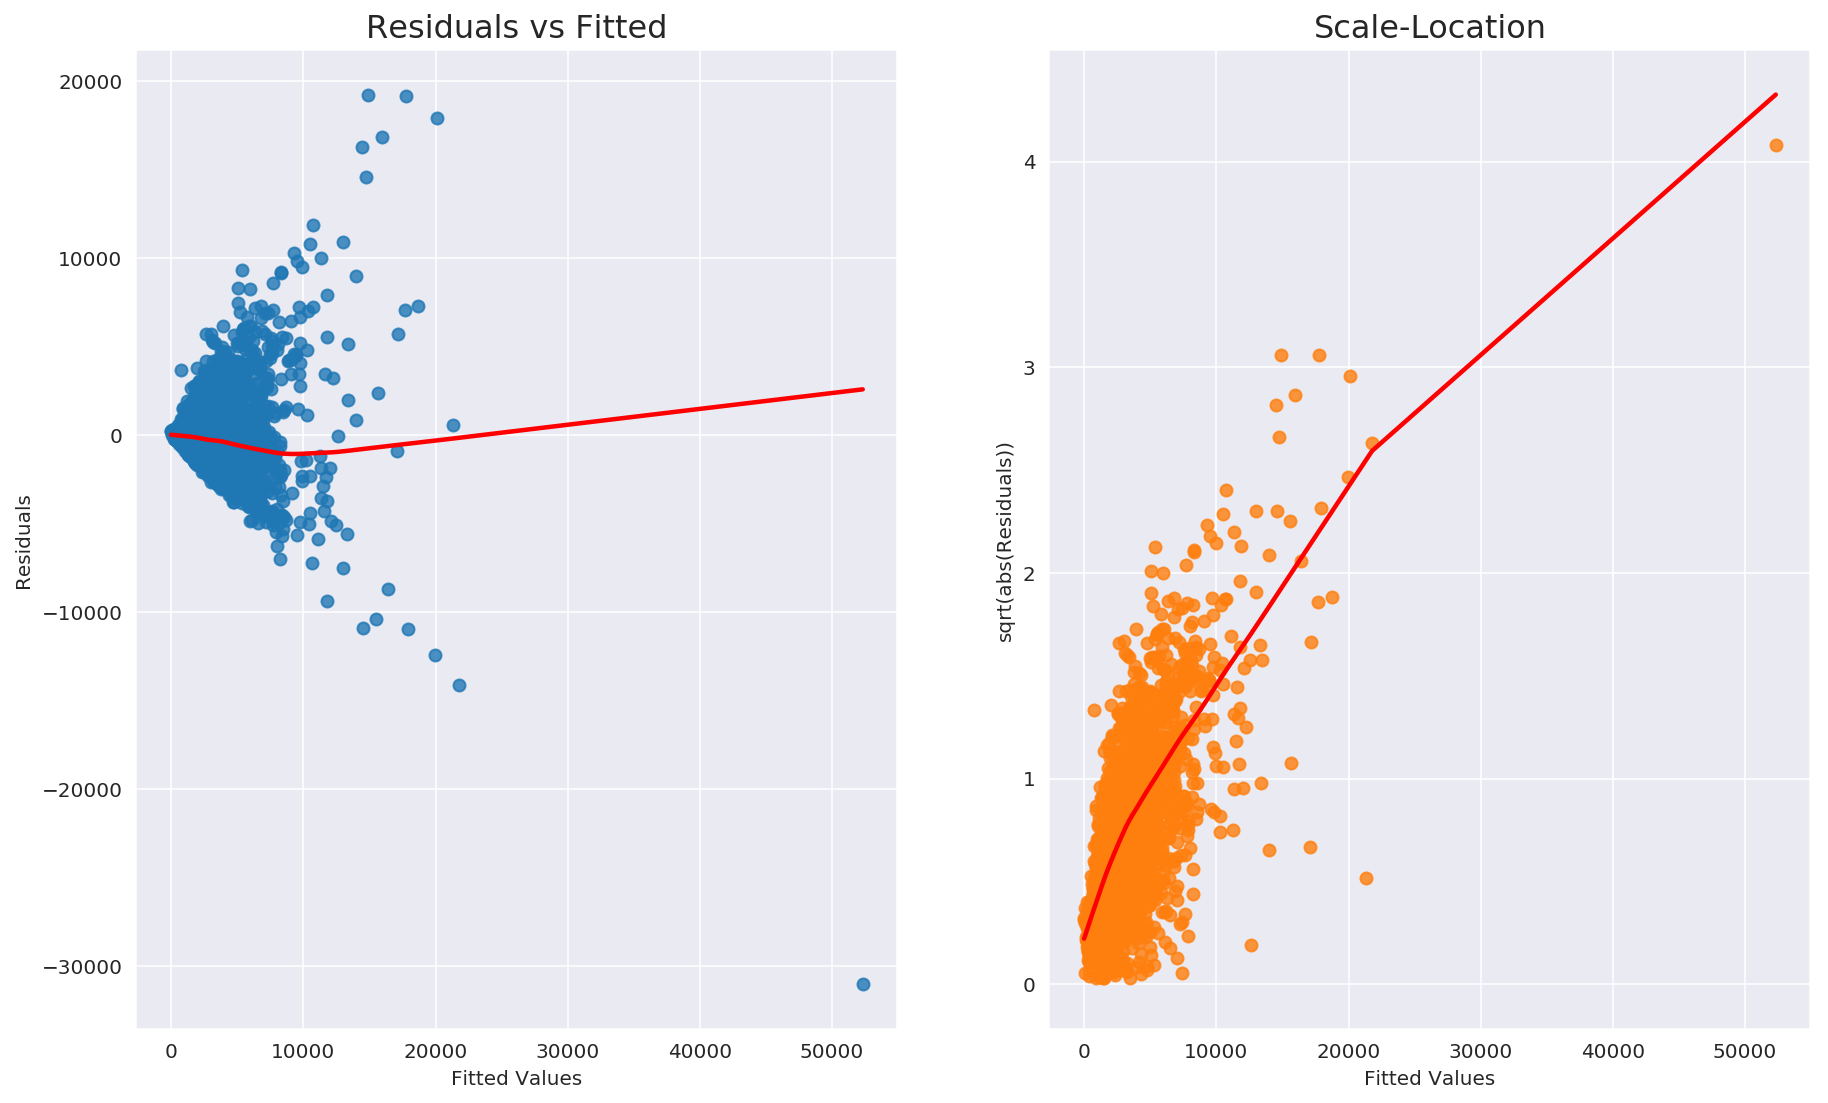

In [ ]:
homoscedasticity_test(lin_reg)

Interpretion: The p-vlaues for Breusch-Pagan test and Goldfeld-Quandt test are significant, so we reject the null hypothesis of equal variance or homoscedasticity.

### Normality of residuals

Jarque-Bera test ---- statistic: 106844.1313, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.8222, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5702, p-value: 0.0000
Anderson-Darling test ---- statistic: 108.2380, 5% critical value: 0.7860
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


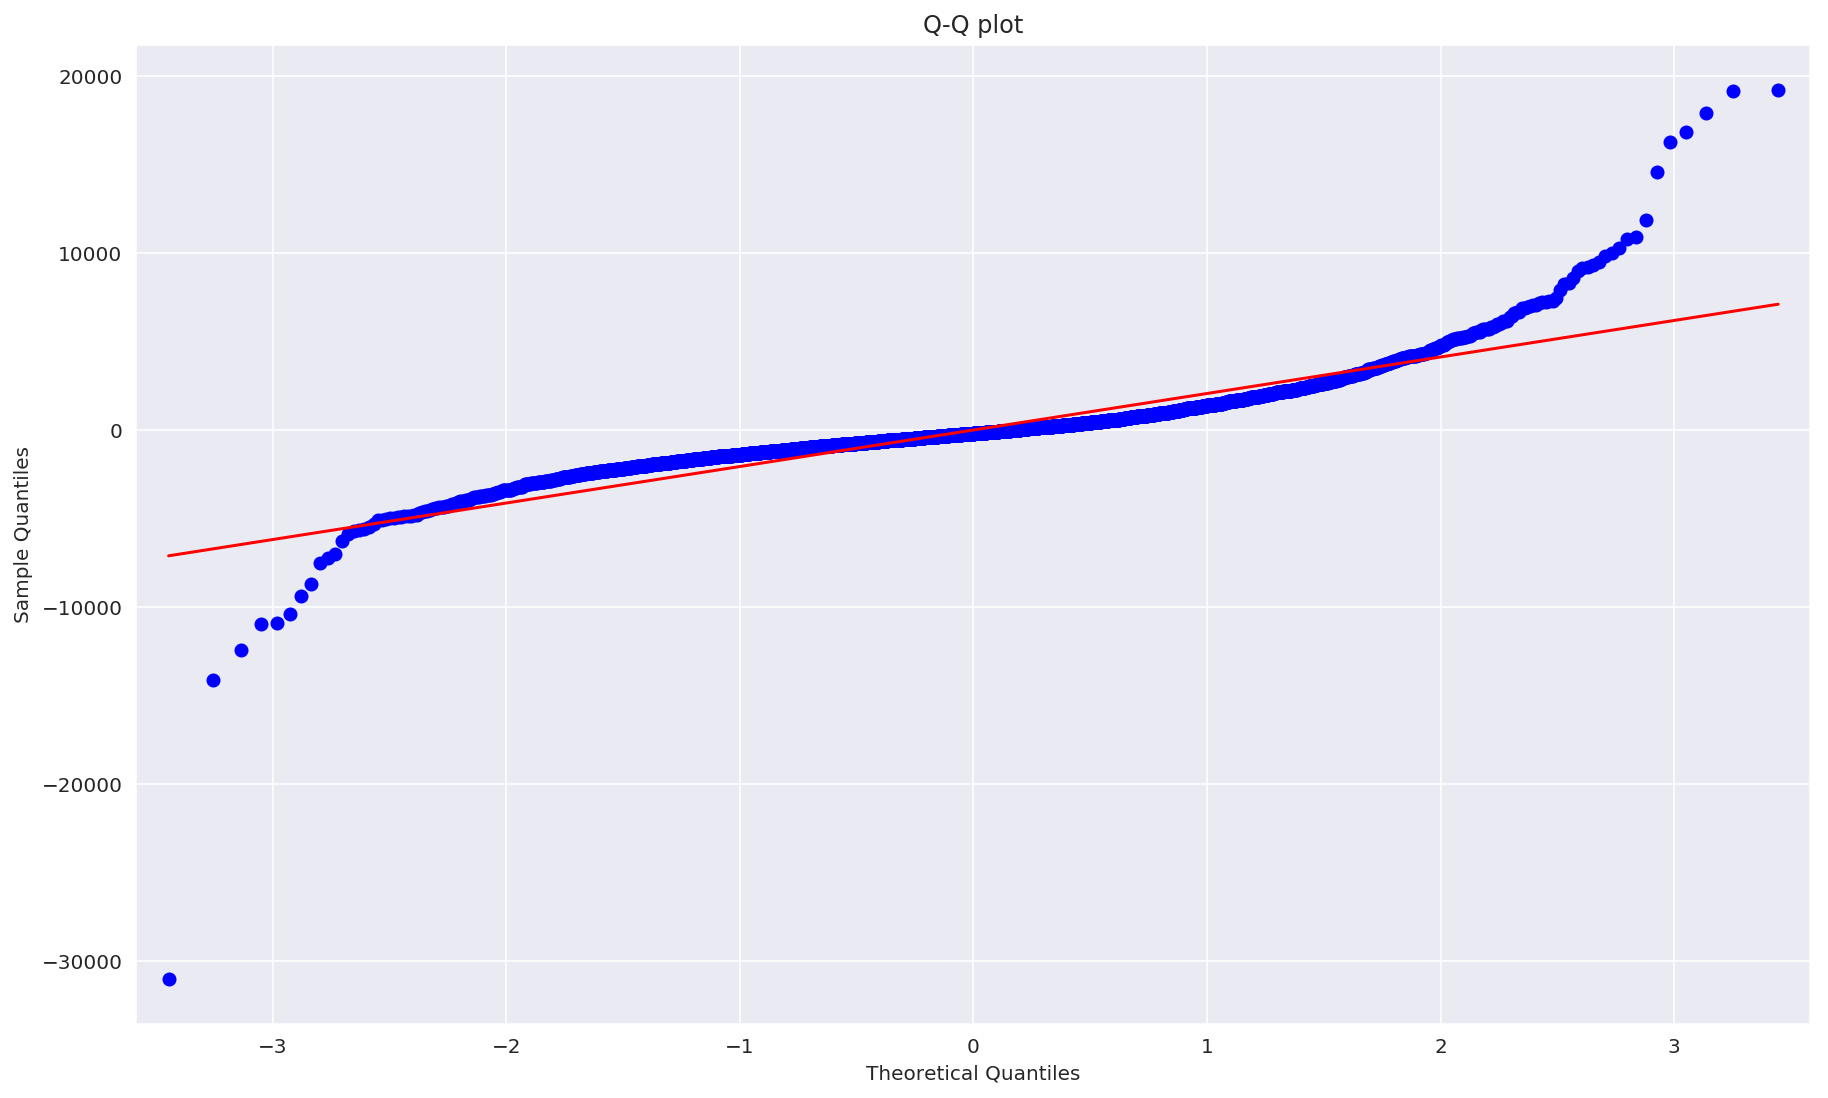

In [ ]:
normality_of_residuals_test(lin_reg)

The distribution (values and shape) indicates excessive skewness and kurtosis in the data (the residuals blue dots around the extermities are not along the normal distribution red line).

## Linear Model 2

In [ ]:
dt2.columns

Index(['pin14', 'pdir', 'pstreet', 'pcity', 'tcity', 'av1', 'value', 'taxes',
       'white', 'black',
       ...
       'log_red_amt_per2', 'walkfac_Somewhat Walkable',
       'walkfac_Very Walkable', 'walkfac_Walker's Paradise', 'log_appeal',
       'log_av1', 'log_value', 'log_taxes', 'log_medhinc', 'log_poverty'],
      dtype='object', length=104)

In [ ]:
dt2.shape

(3524, 104)

In [ ]:

dt3 = dt2[['appeal','av1', 'value', 'taxes',
           'log_appeal','log_av1', 'log_value', 'log_taxes',
           'log_medhinc','medhinc', 'poverty', 'college',  
           "walkfac_Somewhat Walkable","walkfac_Very Walkable", "walkfac_Walker's Paradise" ,
           'avg_school_score', 'condo_Non-condo','homeowner_1', 
           'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County',
           'Area_Code_10', 'Area_Code_11',
           'Area_Code_12', 'Area_Code_13', 'Area_Code_14', 'Area_Code_15',
           'Area_Code_16', 'Area_Code_17', 'Area_Code_18', 'Area_Code_19',
           'Area_Code_20', 'Area_Code_21', 'Area_Code_22', 'Area_Code_23',
           'Area_Code_24', 'Area_Code_25', 'Area_Code_26', 'Area_Code_27',
       'Area_Code_28', 'Area_Code_29', 'Area_Code_30', 'Area_Code_31',
       'Area_Code_32', 'Area_Code_33', 'Sub_Area_Code_02', 'Sub_Area_Code_03',
       'Sub_Area_Code_04', 'Sub_Area_Code_05', 'Sub_Area_Code_06',
       'Sub_Area_Code_07', 'Sub_Area_Code_08', 'Sub_Area_Code_09',
       'Sub_Area_Code_10', 'Sub_Area_Code_11', 'Sub_Area_Code_12',
       'Sub_Area_Code_13', 'Sub_Area_Code_14', 'Sub_Area_Code_15',
       'Sub_Area_Code_16', 'Sub_Area_Code_17', 'Sub_Area_Code_18',
       'Sub_Area_Code_19', 'Sub_Area_Code_20', 'Sub_Area_Code_21',
       'Sub_Area_Code_22', 'Sub_Area_Code_23', 'Sub_Area_Code_24',
       'Sub_Area_Code_25', 'Sub_Area_Code_26', 'Sub_Area_Code_27',
       'Sub_Area_Code_28', 'Sub_Area_Code_29', 'Sub_Area_Code_30',
       'Sub_Area_Code_31', 'Sub_Area_Code_32', 'Sub_Area_Code_33',
       'Sub_Area_Code_34', 'Sub_Area_Code_35', 'Sub_Area_Code_36',
       'race_White', 'ethnicity_Non-hispanic']]

dt3 = dt3.dropna()

#dt3 = dt3.dropna(subset=[ 'av1_log', 'homeowner', 'white','black', 'hispanic', 'asian','medhinc','college', 'squarefoot','logistic','beds' ])
dt3.isna().sum()

dt3.shape

(3499, 81)

In [ ]:
#'tax_rate','tax_rate2',
#'elem_score','high_school_score',
#'appeal',  'appeal2', 'appeal_success', 'log_appeal'
#'red_amt_per', 'log_red_amt_per', 'red_amt_per2', 'log_red_amt_per2',
#       'white', 'black', 'hispanic', 'asian',
#       'walkfac','walkscore',
#Xl2 = dt3[['log_appeal','log_av1', 'log_value', 'log_taxes',
Xl2 = dt3[['av1', 'value', 'taxes','medhinc', 'poverty', 'college',      
       "walkfac_Somewhat Walkable","walkfac_Very Walkable", "walkfac_Walker's Paradise" ,
       'avg_school_score', 
       'condo_Non-condo','homeowner_1', 
       'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County',
       'race_White', 'ethnicity_Non-hispanic',
       'Area_Code_10', 'Area_Code_11',
       'Area_Code_12', 'Area_Code_13', 'Area_Code_14', 'Area_Code_15',
       'Area_Code_16', 'Area_Code_17', 'Area_Code_18', 'Area_Code_19',
       'Area_Code_20', 'Area_Code_21', 'Area_Code_22', 'Area_Code_23',
       'Area_Code_24', 'Area_Code_25', 'Area_Code_26', 'Area_Code_27',
       'Area_Code_28', 'Area_Code_29', 'Area_Code_30', 'Area_Code_31',
       'Area_Code_32', 'Area_Code_33', 'Sub_Area_Code_02', 'Sub_Area_Code_03',
       'Sub_Area_Code_04', 'Sub_Area_Code_05', 'Sub_Area_Code_06',
       'Sub_Area_Code_07', 'Sub_Area_Code_08', 'Sub_Area_Code_09',
       'Sub_Area_Code_10', 'Sub_Area_Code_11', 'Sub_Area_Code_12',
       'Sub_Area_Code_13', 'Sub_Area_Code_14', 'Sub_Area_Code_15',
       'Sub_Area_Code_16', 'Sub_Area_Code_17', 'Sub_Area_Code_18',
       'Sub_Area_Code_19', 'Sub_Area_Code_20', 'Sub_Area_Code_21',
       'Sub_Area_Code_22', 'Sub_Area_Code_23', 'Sub_Area_Code_24',
       'Sub_Area_Code_25', 'Sub_Area_Code_26', 'Sub_Area_Code_27',
       'Sub_Area_Code_28', 'Sub_Area_Code_29', 'Sub_Area_Code_30',
       'Sub_Area_Code_31', 'Sub_Area_Code_32', 'Sub_Area_Code_33',
       'Sub_Area_Code_34', 'Sub_Area_Code_35', 'Sub_Area_Code_36']]


yl2 = dt3['appeal']

Xl2_constant = sm.add_constant(Xl2)

#dt3.isna().sum()

lin_reg2 = sm.OLS(yl2,Xl2_constant).fit()
lin_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 appeal   R-squared:          -3350031136510.210
Model:                            OLS   Adj. R-squared:     -3423432344584.514
Method:                 Least Squares   F-statistic:                    -45.64
Date:                Mon, 11 May 2020   Prob (F-statistic):               1.00
Time:                        05:18:57   Log-Likelihood:                -83578.
No. Observations:                3499   AIC:                         1.673e+05
Df Residuals:                    3423   BIC:                         1.678e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               6167.6246   4.57e+09   1.35e-06      1.000   -8.96e+09    8.96e+09
av1                                -3.393e+04   9.59e+09  -3.54e-06      1.000   -1.88e+10    1.88e+10
value                               1.266e+04   2.33e+10   5.43e-07      1.000   -4.57e+10    4.57e+10
taxes                              -1.108e+04   8.38e+09  -1.32e-06      1.000   -1.64e+10    1.64e+10
medhinc                            -1.054e+04   2.14e+10  -4.93e-07      1.000   -4.19e+10    4.19e+10
poverty                            -2.606e+04   1.28e+10  -2.04e-06      1.000    -2.5e+10     2.5e+10
college                            -1.301e+05   2.75e+10  -4.74e-06      1.000   -5.38e+10    5.38e+10
walkfac_Somewhat Walkable          -5.974e+04   1.19e+10  -5.02e-06      1.000   -2.34e+10    2.34e+10
walkfac_Very Walkable              -7.855e+04   2.18e+10   -3.6e-06      1.000   -4.28e+10    4.28e+10
walkfac_Walker's Paradise           4075.2262   1.58e+10   2.57e-07      1.000   -3.11e+10    3.11e+10
avg_school_score                    5.817e+04   3.44e+10   1.69e-06      1.000   -6.74e+10    6.74e+10
condo_Non-condo                    -9.178e+04   4.16e+10  -2.21e-06      1.000   -8.15e+10    8.15e+10
homeowner_1                        -6.279e+04   4.12e+10  -1.53e-06      1.000   -8.07e+10    8.07e+10
tri_Northwest Suburban Cook County  6.406e+04    2.2e+10   2.91e-06      1.000   -4.32e+10    4.32e+10
tri_Southwest Suburban Cook County -2.301e+04   1.46e+10  -1.57e-06      1.000   -2.87e+10    2.87e+10
race_White                         -4.774e+04   2.76e+10  -1.73e-06      1.000    -5.4e+10     5.4e+10
ethnicity_Non-hispanic              -8.39e+04   2.31e+10  -3.63e-06      1.000   -4.54e+10    4.54e+10
Area_Code_10                       -1290.2684   9.34e+09  -1.38e-07      1.000   -1.83e+10    1.83e+10
Area_Code_11                       -4.254e+04   1.31e+10  -3.25e-06      1.000   -2.56e+10    2.56e+10
Area_Code_12                        3.976e+04   1.51e+10   2.64e-06      1.000   -2.95e+10    2.95e+10
Area_Code_13                        3826.0999    2.6e+10   1.47e-07      1.000   -5.09e+10    5.09e+10
Area_Code_14                          2.9e+04   1.68e+10   1.73e-06      1.000   -3.29e+10    3.29e+10
Area_Code_15                         9.73e+04   1.64e+10   5.92e-06      1.000   -3.22e+10    3.22e+10
Area_Code_16                        7.094e+04   2.48e+10   2.86e-06      1.000   -4.87e+10    4.87e+10
Area_Code_17                        1.023e+04   2.13e+10   4.81e-07      1.000   -4.18e+10    4.18e+10
Area_Code_18                        3.443e+04   1.67e+10   2.06e-06      1.000   -3.27e+10    3.27e+10
Area_Code_19                        9.631e+04   2.26e+10   4.26e-06      1.000   -4.43e+10    4.

### Assumption check

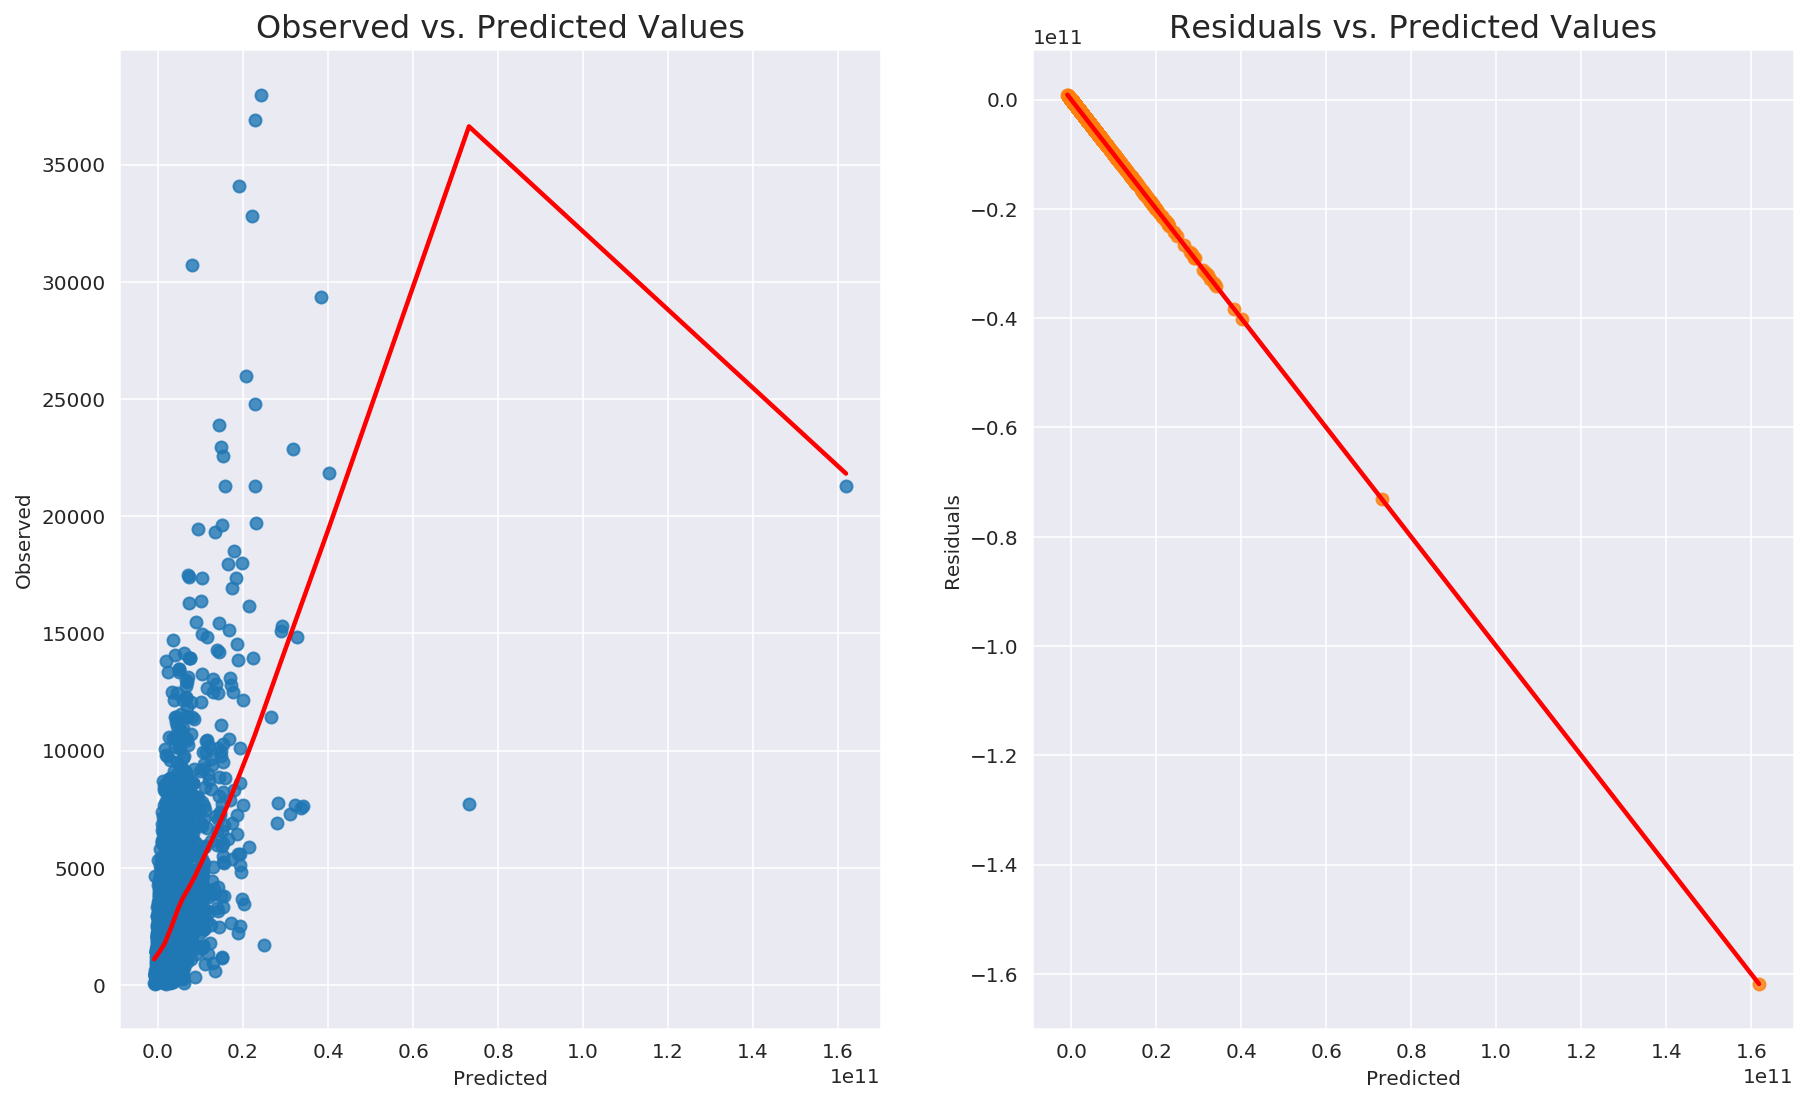

In [ ]:
linearity_test(lin_reg2, yl2) 

### multicollinearity check

In [ ]:
Xl2_constant.shape

(3499, 76)

In [ ]:
#multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(Xl2_constant.values, i) for i in range(Xl2_constant.shape[1])]
VIFs = pd.DataFrame({'vif': vif[1:]}, index=Xl2.columns).T

VIFs

,av1,value,taxes,medhinc,poverty,college,walkfac_Somewhat Walkable,walkfac_Very Walkable,walkfac_Walker's Paradise,avg_school_score,...,Sub_Area_Code_27,Sub_Area_Code_28,Sub_Area_Code_29,Sub_Area_Code_30,Sub_Area_Code_31,Sub_Area_Code_32,Sub_Area_Code_33,Sub_Area_Code_34,Sub_Area_Code_35,Sub_Area_Code_36
vif,6.219914e-15,1.280214e-10,3.284191e-13,1.307571e-13,1.212270e-12,5.458946e-15,2.628863e-15,1.354581e-13,5.917196e-15,2.542442e-15,...,2.603467e-15,2.402984e-15,1.761445e-15,1.340018e-14,4.925995e-16,2.132686e-15,4.840238e-15,9.445436e-15,1.200353e-14,5.297950e-13


High Multicollinearity among Race, ethnicity, college and school ratings

### homoscedasticity_test


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic -3.914774e+17
p-value                        1.000000e+00
f-value                       -4.564000e+01
f p-value                      1.000000e+00

 Goldfeld-Quandt test ----
                value
F statistic  0.509189
p-value      1.000000

 Residuals plots ----


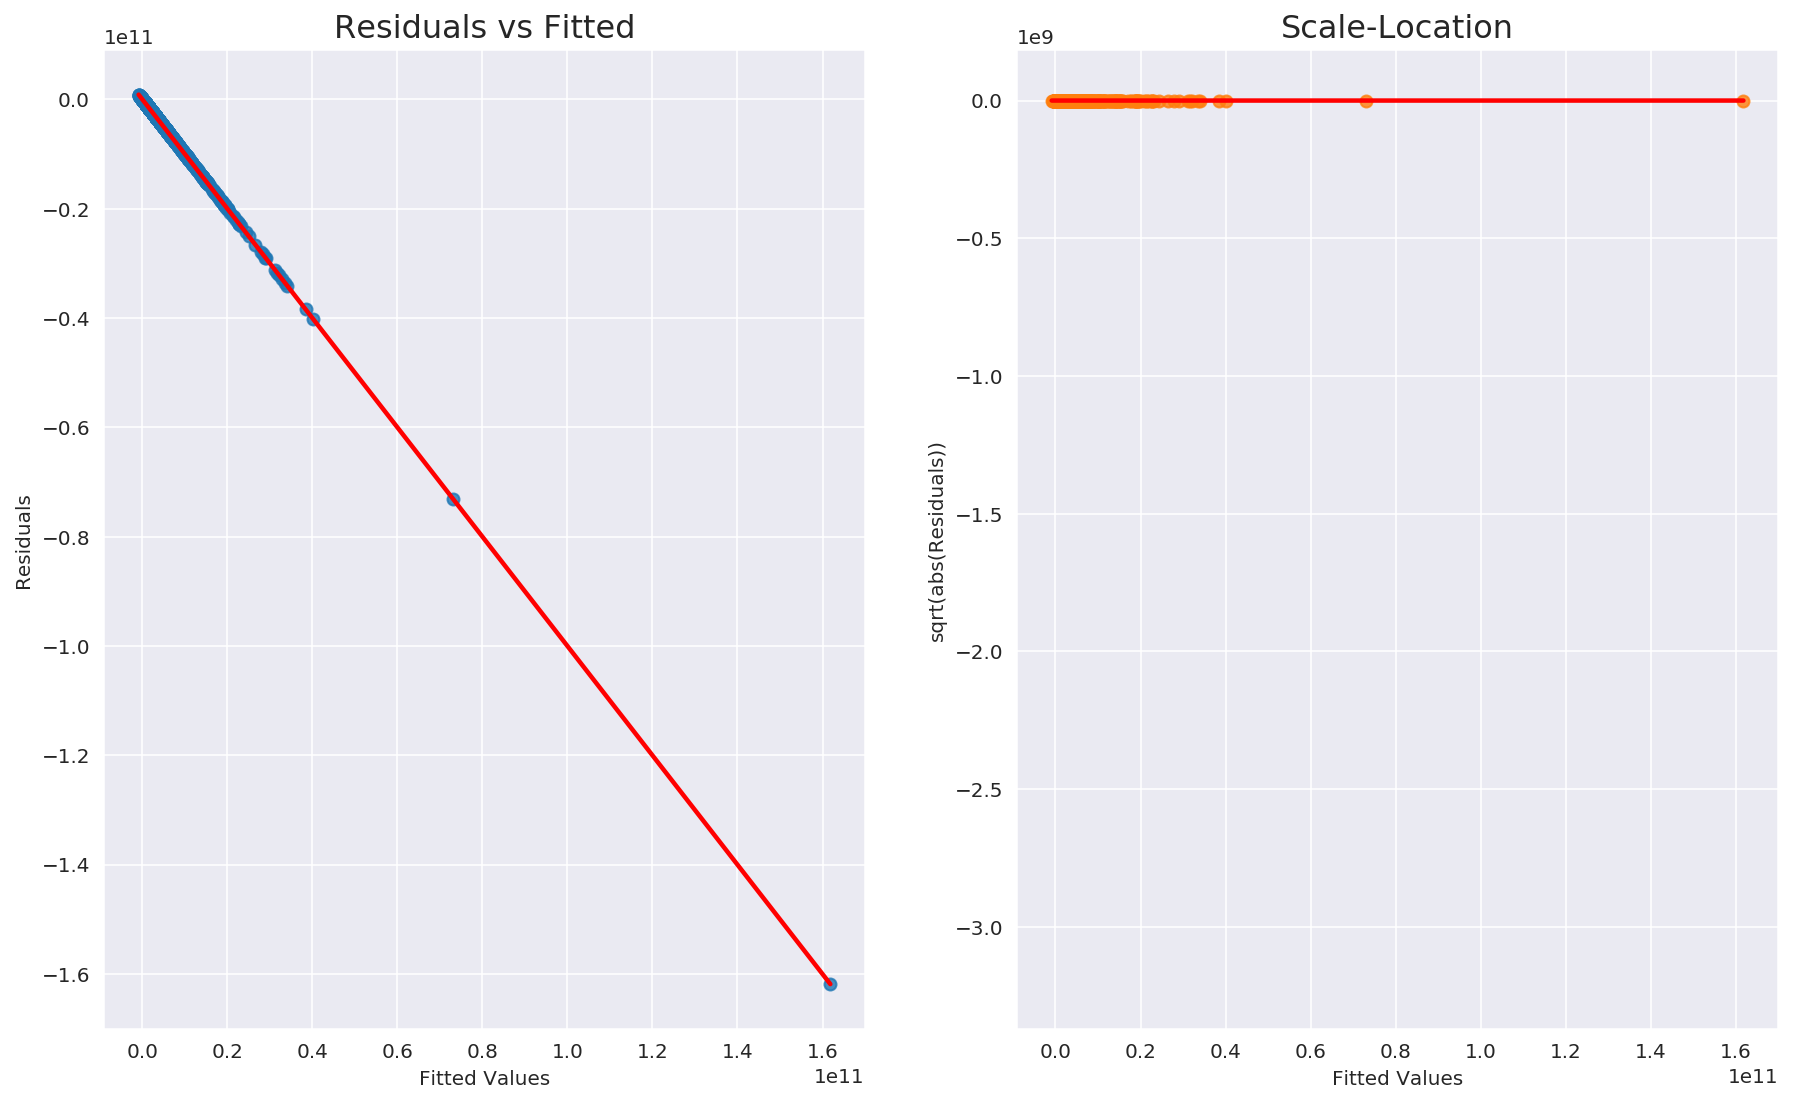

In [ ]:
homoscedasticity_test(lin_reg2)

Interpretion: The p-vlaues for Breusch-Pagan test and Goldfeld-Quandt test are significant, so we reject the null hypothesis of equal variance or homoscedasticity.

### Normality of residuals

Jarque-Bera test ---- statistic: 20990626.9413, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.4737, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.9694, p-value: 0.0000
Anderson-Darling test ---- statistic: 369.9080, 5% critical value: 0.7860
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


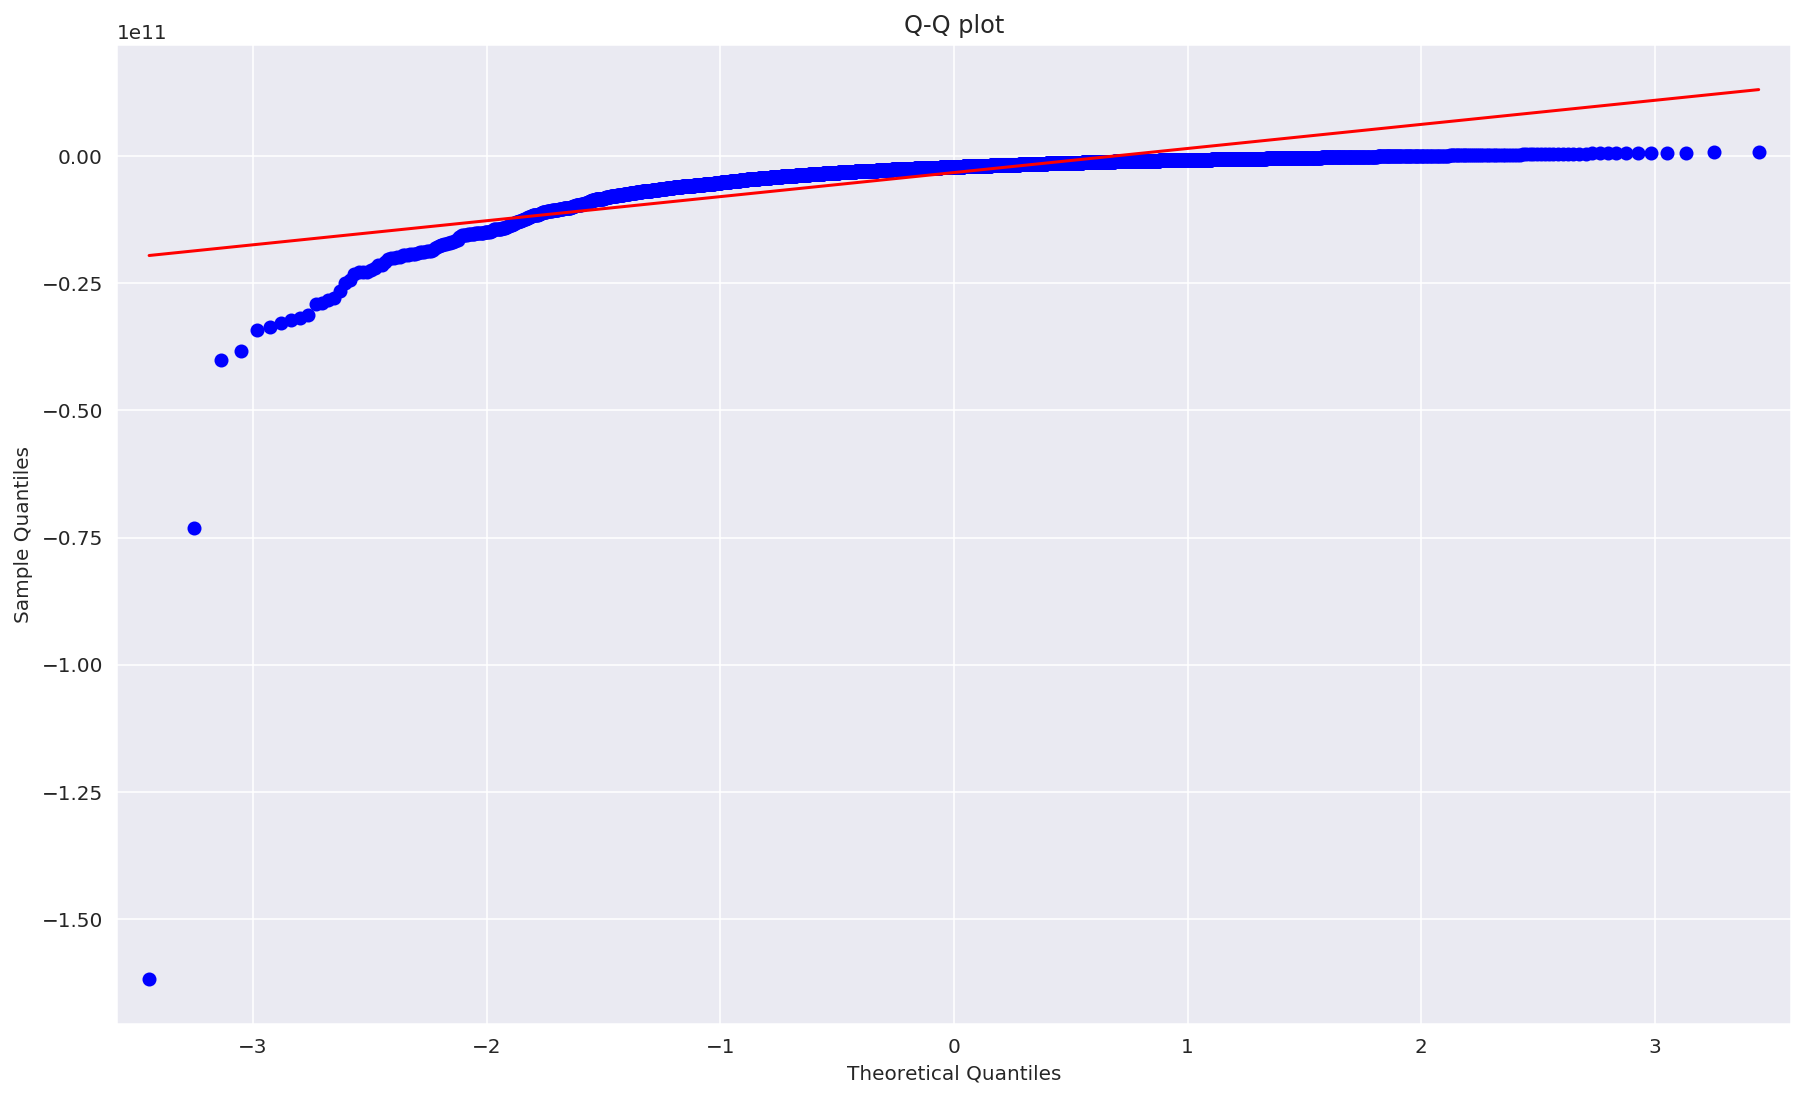

In [ ]:
normality_of_residuals_test(lin_reg2)

The distribution (values and shape) indicates excessive skewness and kurtosis in the data (the residuals blue dots around the extermities are not along the normal distribution red line).

# Linear Model 3

Drop all Area and Sub area - those are insignificant

In [ ]:

dt4 = dt2[['log_appeal','log_av1', 'log_value', 'log_taxes',
           'appeal','av1','value','taxes',
       'medhinc', 'poverty', 'college',      
       "walkfac_Somewhat Walkable","walkfac_Very Walkable", "walkfac_Walker's Paradise" ,
       'avg_school_score', 
       'condo_Non-condo','homeowner_1', 
       'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County',
       'Area_Code_10', 'Area_Code_11',
       'Area_Code_12', 'Area_Code_13', 'Area_Code_14', 'Area_Code_15',
       'Area_Code_16', 'Area_Code_17', 'Area_Code_18', 'Area_Code_19',
       'Area_Code_20', 'Area_Code_21', 'Area_Code_22', 'Area_Code_23',
       'Area_Code_24', 'Area_Code_25', 'Area_Code_26', 'Area_Code_27',
       'Area_Code_28', 'Area_Code_29', 'Area_Code_30', 'Area_Code_31',
       'Area_Code_32', 'Area_Code_33', 'Sub_Area_Code_02', 'Sub_Area_Code_03',
       'Sub_Area_Code_04', 'Sub_Area_Code_05', 'Sub_Area_Code_06',
       'Sub_Area_Code_07', 'Sub_Area_Code_08', 'Sub_Area_Code_09',
       'Sub_Area_Code_10', 'Sub_Area_Code_11', 'Sub_Area_Code_12',
       'Sub_Area_Code_13', 'Sub_Area_Code_14', 'Sub_Area_Code_15',
       'Sub_Area_Code_16', 'Sub_Area_Code_17', 'Sub_Area_Code_18',
       'Sub_Area_Code_19', 'Sub_Area_Code_20', 'Sub_Area_Code_21',
       'Sub_Area_Code_22', 'Sub_Area_Code_23', 'Sub_Area_Code_24',
       'Sub_Area_Code_25', 'Sub_Area_Code_26', 'Sub_Area_Code_27',
       'Sub_Area_Code_28', 'Sub_Area_Code_29', 'Sub_Area_Code_30',
       'Sub_Area_Code_31', 'Sub_Area_Code_32', 'Sub_Area_Code_33',
       'Sub_Area_Code_34', 'Sub_Area_Code_35', 'Sub_Area_Code_36',
       'race_White', 'ethnicity_Non-hispanic']]

dt4 = dt4.dropna()

#dt3 = dt3.dropna(subset=[ 'av1_log', 'homeowner', 'white','black', 'hispanic', 'asian','medhinc','college', 'squarefoot','logistic','beds' ])
dt4.isna().sum()

dt4.shape

(3499, 80)

Using log_appeal

In [ ]:
#'tax_rate','tax_rate2',
#'elem_score','high_school_score',
#'appeal',  'appeal2', 'appeal_success', 'log_appeal'
#'red_amt_per', 'log_red_amt_per', 'red_amt_per2', 'log_red_amt_per2',
#       'white', 'black', 'hispanic', 'asian',
#       'walkfac','walkscore',

Xl3 = dt4[['log_av1', 'log_value', 'log_taxes',
       'medhinc', 'poverty', 'college',      
       "walkfac_Somewhat Walkable","walkfac_Very Walkable", "walkfac_Walker's Paradise" ,
       'avg_school_score', 
       'condo_Non-condo','homeowner_1', 
       'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County',
       'race_White', 'ethnicity_Non-hispanic']]


yl3 = dt4['log_appeal']

Xl3_constant = sm.add_constant(Xl3)

#dt3.isna().sum()

lin_reg3 = sm.OLS(yl3,Xl3_constant).fit()
lin_reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_appeal   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     329.1
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        05:25:47   Log-Likelihood:                -2997.9
No. Observations:                3499   AIC:                             6030.
Df Residuals:                    3482   BIC:                             6134.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.3289      0.212     -6.272      0.000      -1.744      -0.913
log_av1                                0.5927      0.046     12.824      0.000       0.502       0.683
log_value                             -0.0424      0.027     -1.572      0.116      -0.095       0.010
log_taxes                              0.3806      0.039      9.720      0.000       0.304       0.457
medhinc                             4.899e-07      6e-07      0.816      0.414   -6.87e-07    1.67e-06
poverty                                0.2165      0.175      1.239      0.215      -0.126       0.559
college                                0.0464      0.111      0.419      0.675      -0.171       0.263
walkfac_Somewhat Walkable             -0.0327      0.033     -1.004      0.316      -0.097       0.031
walkfac_Very Walkable                 -0.0078      0.037     -0.210      0.834      -0.081       0.065
walkfac_Walker's Paradise             -0.0046      0.047     -0.098      0.922      -0.097       0.088
avg_school_score                       0.0002      0.006      0.027      0.978      -0.012       0.012
condo_Non-condo                        0.0443      0.035      1.253      0.210      -0.025       0.113
homeowner_1                           -0.0428      0.020     -2.096      0.036      -0.083      -0.003
tri_Northwest Suburban Cook County     0.0431      0.044      0.970      0.332      -0.044       0.130
tri_Southwest Suburban Cook County     0.0671      0.038      1.776      0.076      -0.007       0.141
race_White                            -0.0558      0.036     -1.551      0.121      -0.126       0.015
ethnicity_Non-hispanic                 0.0535      0.047      1.137      0.256      -0.039       0.146
==============================================================================
Omnibus:                      141.693   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.026
Skew:                          -0.481   Prob(JB):                     4.36e-33
Kurtosis:                       2.690   Cond. No.                     1.79e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Assumption check

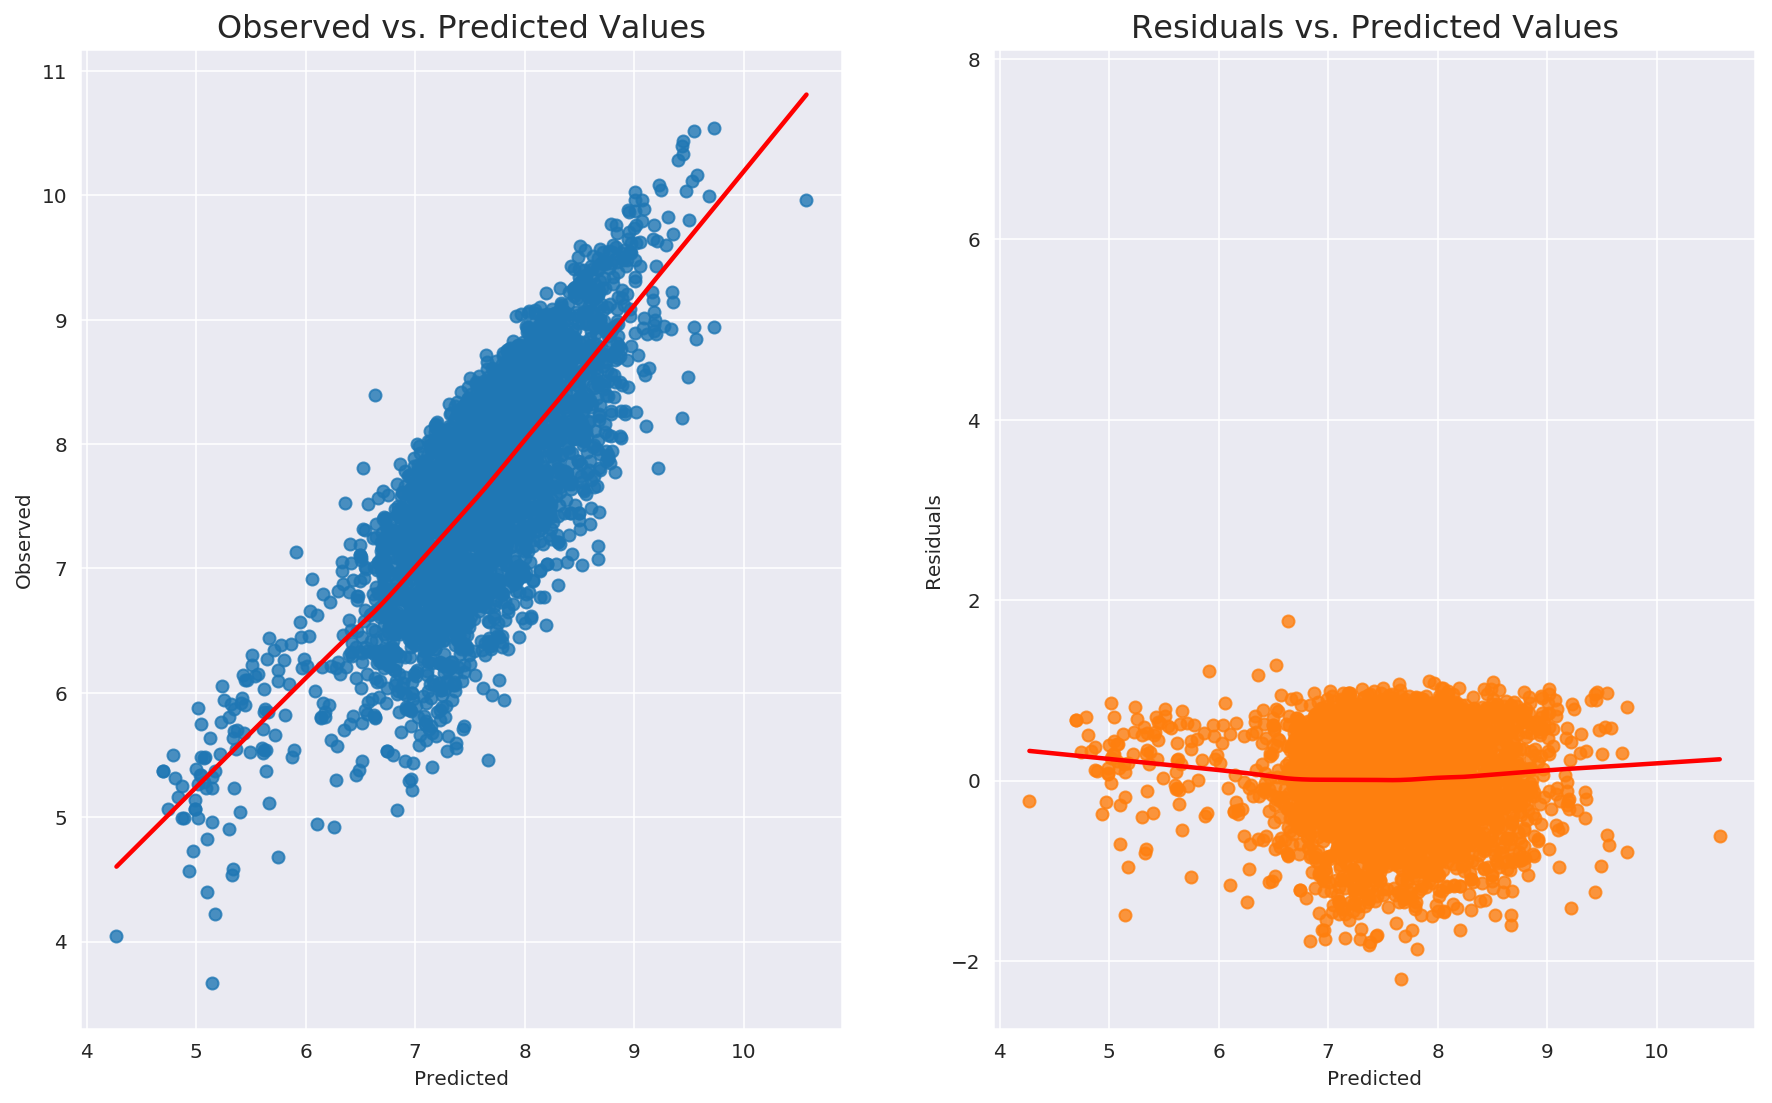

In [ ]:
linearity_test(lin_reg3, yl3) 

### multicollinearity check

In [ ]:
Xl3_constant.shape

(3499, 17)

In [ ]:
#multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(Xl3_constant.values, i) for i in range(Xl3_constant.shape[1])]
VIFs = pd.DataFrame({'vif': vif[1:]}, index=Xl3.columns)

#VIFs = pd.DataFrame({"VIF":VIF_values}, index=ind_variables.columns) #Turn our list of VIFs into a dataframe
VIFs

,vif
log_av1,13.108766
log_value,4.203934
log_taxes,9.514369
medhinc,2.723640
poverty,2.104531
college,5.828614
walkfac_Somewhat Walkable,1.717463
walkfac_Very Walkable,3.139609
walkfac_Walker's Paradise,5.085954
avg_school_score,1.722681


High Multicollinearity among av1, value, taxes

### homoscedasticity_test


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  7.080220e+01
p-value                        7.217735e-09
f-value                        4.494586e+00
f p-value                      5.844669e-09

 Goldfeld-Quandt test ----
                value
F statistic  0.982363
p-value      0.644409

 Residuals plots ----


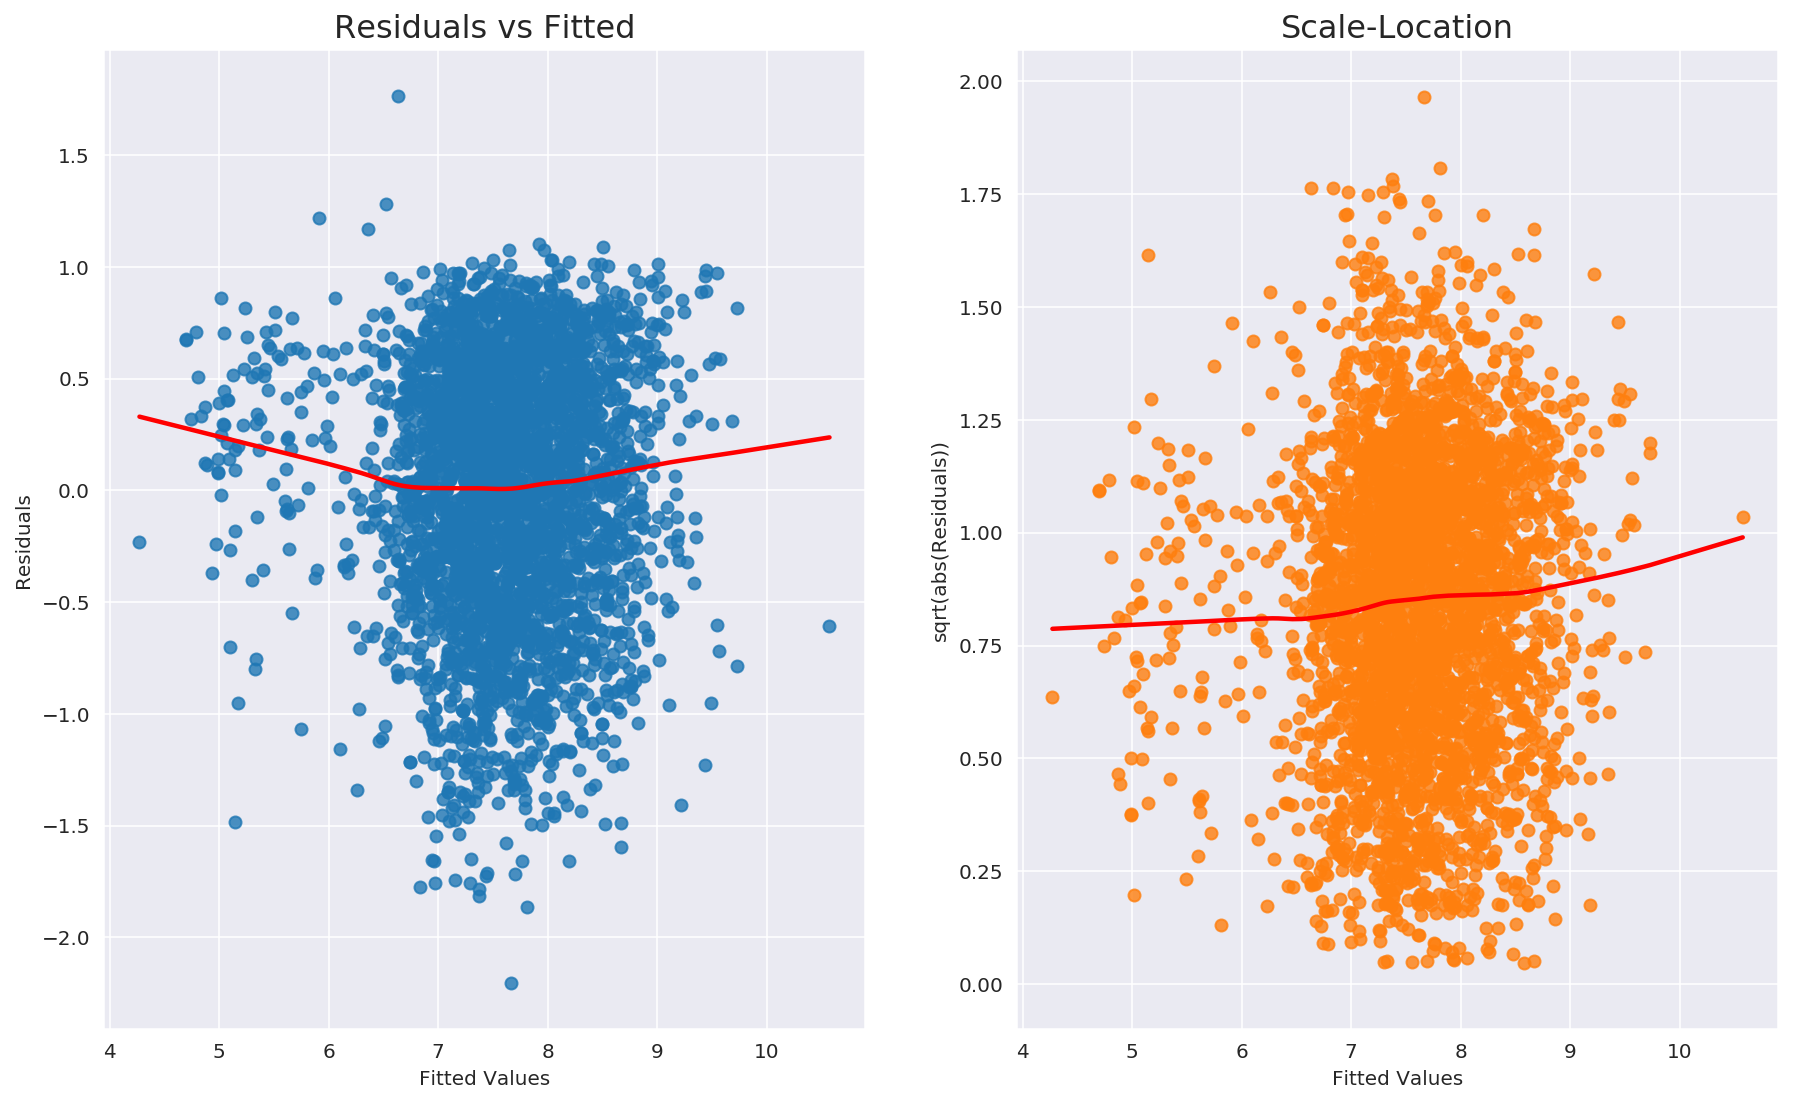

In [ ]:
homoscedasticity_test(lin_reg3)

Interpretion: The p-vlaues for Breusch-Pagan test and Goldfeld-Quandt test are significant, so we reject the null hypothesis of equal variance or homoscedasticity.

### Normality of residuals

Jarque-Bera test ---- statistic: 149.0263, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9755, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.1686, p-value: 0.0000
Anderson-Darling test ---- statistic: 22.2454, 5% critical value: 0.7860
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


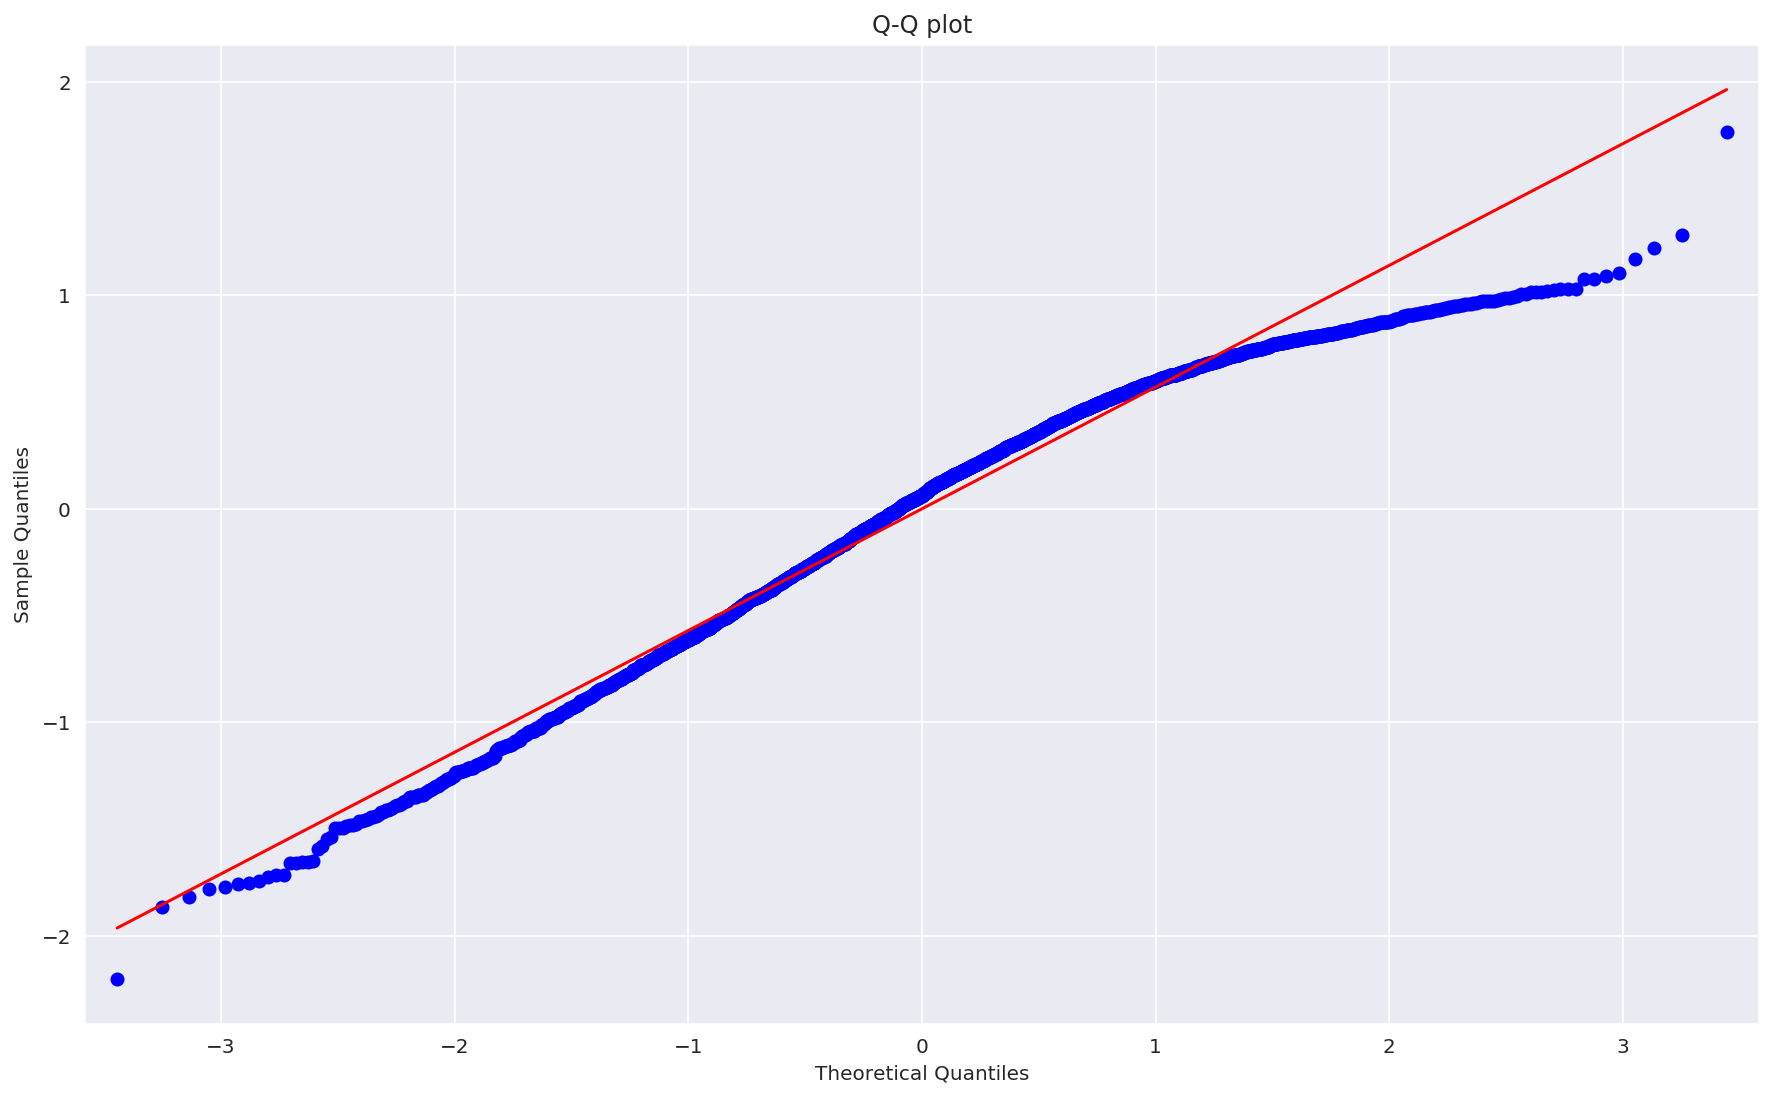

In [ ]:
normality_of_residuals_test(lin_reg3)

The distribution (values and shape) indicates excessive skewness and kurtosis in the data (the residuals blue dots around the extermities are not along the normal distribution red line).

## Checking Outliers based on Cooks' Distance

In [ ]:
import statsmodels.stats. outliers_influence as sms
#influence = sms.outliers_influence.OLSInfluence(res2)
influence = sms.OLSInfluence(lin_reg3)
cooksD = influence.cooks_distance

In [ ]:
print('the maximum of Cooks Distance is %f' %cooksD[0].max())
print('the minimum of Cooks Distance is %f' %cooksD[0].min())
print('the mean value of Cooks Distance is %f' %cooksD[0].mean())
print('the standard deviation of Cooks Distance is %f' %cooksD[0].std())

the maximum of Cooks Distance is 0.007458
the minimum of Cooks Distance is 0.000000
the mean value of Cooks Distance is 0.000276
the standard deviation of Cooks Distance is 0.000408


The maximum Cooks' Distance is really low, which means all the observation points are closed to our fit hyperplane.

## Weighted Linear Regression

Since the homoscedasticity test is failed, an attempt to create a weighted linear regression model is made.

In [ ]:
## Creat Hat matrix based on linear model 3
a = np.linalg.inv(np.dot(Xl3.T,Xl3))
hatMat = np.dot(Xl3,a)
hatMat = np.dot(hatMat,Xl3.T)
D = np.diagonal(hatMat) # diagonal elements of hat matrix

In [ ]:
sigma_sq = lin_reg3.mse_resid
sigma = np.sqrt(sigma_sq)
sigma

0.5713635482307509

In [ ]:
# Calculate the weight array for each observation.
w = []
for d in D:
    w.append(1./(sigma*(1-d)))

In [ ]:
weighted_lin_reg3 = sm.WLS(yl3,Xl3_constant,weights = w).fit()
weighted_lin_reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             log_appeal   R-squared:                       0.602
Model:                            WLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     329.6
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        05:36:52   Log-Likelihood:                -2997.5
No. Observations:                3499   AIC:                             6029.
Df Residuals:                    3482   BIC:                             6134.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.3285      0.212     -6.272      0.000      -1.744      -0.913
log_av1                                0.5920      0.046     12.827      0.000       0.502       0.683
log_value                             -0.0419      0.027     -1.559      0.119      -0.095       0.011
log_taxes                              0.3808      0.039      9.731      0.000       0.304       0.457
medhinc                             4.894e-07      6e-07      0.816      0.415   -6.86e-07    1.67e-06
poverty                                0.2169      0.174      1.243      0.214      -0.125       0.559
college                                0.0467      0.111      0.422      0.673      -0.170       0.263
walkfac_Somewhat Walkable             -0.0326      0.033     -1.000      0.317      -0.097       0.031
walkfac_Very Walkable                 -0.0077      0.037     -0.208      0.835      -0.081       0.065
walkfac_Walker's Paradise             -0.0045      0.047     -0.096      0.923      -0.097       0.088
avg_school_score                       0.0002      0.006      0.029      0.977      -0.011       0.012
condo_Non-condo                        0.0444      0.035      1.257      0.209      -0.025       0.114
homeowner_1                           -0.0428      0.020     -2.097      0.036      -0.083      -0.003
tri_Northwest Suburban Cook County     0.0429      0.044      0.968      0.333      -0.044       0.130
tri_Southwest Suburban Cook County     0.0670      0.038      1.776      0.076      -0.007       0.141
race_White                            -0.0559      0.036     -1.553      0.121      -0.126       0.015
ethnicity_Non-hispanic                 0.0536      0.047      1.140      0.254      -0.039       0.146
==============================================================================
Omnibus:                      141.609   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.877
Skew:                          -0.481   Prob(JB):                     4.70e-33
Kurtosis:                       2.690   Cond. No.                     1.78e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The adjusted R square has no change, which propobly indicate that different variance doesn't harm the fitted model too much

# Linear Model 4

In [ ]:

dt5 = dt2[['log_appeal','log_av1', 'log_value', 'log_taxes',
           'appeal','av1','value','taxes',
       'medhinc', 'poverty', 'college',      
       "walkfac_Somewhat Walkable","walkfac_Very Walkable", "walkfac_Walker's Paradise" ,
       'avg_school_score', 
       'condo_Non-condo','homeowner_1', 
       'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County',
       'race_White', 'ethnicity_Non-hispanic']]

dt5 = dt5.dropna()

#dt3 = dt3.dropna(subset=[ 'av1_log', 'homeowner', 'white','black', 'hispanic', 'asian','medhinc','college', 'squarefoot','logistic','beds' ])
dt5.isna().sum()

dt5.shape

(3499, 21)

In [ ]:
#'tax_rate','tax_rate2',
#'elem_score','high_school_score',
#'appeal',  'appeal2', 'appeal_success', 'log_appeal'
#'red_amt_per', 'log_red_amt_per', 'red_amt_per2', 'log_red_amt_per2',
#       'white', 'black', 'hispanic', 'asian',
#       'walkfac','walkscore',

Xl4 = dt5[['log_av1', 'log_value', 'log_taxes',
       'medhinc', 'poverty', 'college',      
       "walkfac_Somewhat Walkable","walkfac_Very Walkable", "walkfac_Walker's Paradise" ,
       'avg_school_score', 
       'condo_Non-condo','homeowner_1', 
       'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County',
       'race_White', 'ethnicity_Non-hispanic']]


yl4 = dt5['log_appeal']

Xl4_constant = sm.add_constant(Xl4)

#dt3.isna().sum()

lin_reg4 = sm.OLS(yl4,Xl4_constant).fit()
lin_reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_appeal   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     329.1
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        05:38:09   Log-Likelihood:                -2997.9
No. Observations:                3499   AIC:                             6030.
Df Residuals:                    3482   BIC:                             6134.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.3289      0.212     -6.272      0.000      -1.744      -0.913
log_av1                                0.5927      0.046     12.824      0.000       0.502       0.683
log_value                             -0.0424      0.027     -1.572      0.116      -0.095       0.010
log_taxes                              0.3806      0.039      9.720      0.000       0.304       0.457
medhinc                             4.899e-07      6e-07      0.816      0.414   -6.87e-07    1.67e-06
poverty                                0.2165      0.175      1.239      0.215      -0.126       0.559
college                                0.0464      0.111      0.419      0.675      -0.171       0.263
walkfac_Somewhat Walkable             -0.0327      0.033     -1.004      0.316      -0.097       0.031
walkfac_Very Walkable                 -0.0078      0.037     -0.210      0.834      -0.081       0.065
walkfac_Walker's Paradise             -0.0046      0.047     -0.098      0.922      -0.097       0.088
avg_school_score                       0.0002      0.006      0.027      0.978      -0.012       0.012
condo_Non-condo                        0.0443      0.035      1.253      0.210      -0.025       0.113
homeowner_1                           -0.0428      0.020     -2.096      0.036      -0.083      -0.003
tri_Northwest Suburban Cook County     0.0431      0.044      0.970      0.332      -0.044       0.130
tri_Southwest Suburban Cook County     0.0671      0.038      1.776      0.076      -0.007       0.141
race_White                            -0.0558      0.036     -1.551      0.121      -0.126       0.015
ethnicity_Non-hispanic                 0.0535      0.047      1.137      0.256      -0.039       0.146
==============================================================================
Omnibus:                      141.693   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.026
Skew:                          -0.481   Prob(JB):                     4.36e-33
Kurtosis:                       2.690   Cond. No.                     1.79e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Linear Model 5

In [ ]:
dt5 = dt2[['log_appeal','log_value', 'log_taxes',
       'medhinc', 'poverty', 'college',      
       "walkfac_Somewhat Walkable","walkfac_Very Walkable", "walkfac_Walker's Paradise" ,
       'avg_school_score', 
       'condo_Non-condo','homeowner_1', 
       'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County',
       'race_White', 'ethnicity_Non-hispanic']]

dt5.dropna(inplace=True)
dt5.shape

(3499, 16)

In [ ]:
Xl5 = dt5[['log_value', 'log_taxes',
       'medhinc', 'poverty', 'college',      
       "walkfac_Somewhat Walkable","walkfac_Very Walkable", "walkfac_Walker's Paradise" ,
       'avg_school_score', 
       'condo_Non-condo','homeowner_1', 
       'tri_Northwest Suburban Cook County','tri_Southwest Suburban Cook County',
       'race_White', 'ethnicity_Non-hispanic']]

yl5 = dt5['log_appeal']


Xl5_constant = sm.add_constant(Xl5)

lin_reg5 = sm.OLS(yl5,Xl5_constant).fit()
lin_reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_appeal   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     324.9
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        05:38:47   Log-Likelihood:                -3078.6
No. Observations:                3499   AIC:                             6189.
Df Residuals:                    3483   BIC:                             6288.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.8396      0.213     -3.937      0.000      -1.258      -0.422
log_value                              0.1115      0.025      4.518      0.000       0.063       0.160
log_taxes                              0.8056      0.021     37.728      0.000       0.764       0.847
medhinc                             4.454e-07   6.14e-07      0.726      0.468   -7.58e-07    1.65e-06
poverty                                0.2407      0.179      1.346      0.178      -0.110       0.591
college                                0.0079      0.113      0.069      0.945      -0.214       0.230
walkfac_Somewhat Walkable             -0.0395      0.033     -1.183      0.237      -0.105       0.026
walkfac_Very Walkable                 -0.0181      0.038     -0.473      0.636      -0.093       0.057
walkfac_Walker's Paradise             -0.0359      0.048     -0.747      0.455      -0.130       0.058
avg_school_score                       0.0133      0.006      2.213      0.027       0.002       0.025
condo_Non-condo                        0.0790      0.036      2.193      0.028       0.008       0.150
homeowner_1                            0.0091      0.020      0.445      0.656      -0.031       0.049
tri_Northwest Suburban Cook County    -0.1392      0.043     -3.234      0.001      -0.224      -0.055
tri_Southwest Suburban Cook County    -0.1296      0.035     -3.672      0.000      -0.199      -0.060
race_White                            -0.0037      0.037     -0.102      0.919      -0.075       0.068
ethnicity_Non-hispanic                 0.0322      0.048      0.668      0.504      -0.062       0.127
==============================================================================
Omnibus:                      146.493   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.873
Skew:                          -0.491   Prob(JB):                     2.34e-34
Kurtosis:                       2.690   Cond. No.                     1.76e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(Xl5_constant.values, i) for i in range(Xl5_constant.shape[1])]
VIFs = pd.DataFrame({'vif': vif[1:]}, index=Xl5.columns)

#VIFs = pd.DataFrame({"VIF":VIF_values}, index=ind_variables.columns) #Turn our list of VIFs into a dataframe
VIFs

,vif
log_value,3.370152
log_taxes,2.701841
medhinc,2.723549
poverty,2.104284
college,5.824316
walkfac_Somewhat Walkable,1.717016
walkfac_Very Walkable,3.138170
walkfac_Walker's Paradise,5.072237
avg_school_score,1.671790
condo_Non-condo,2.791263
